# Introduction: TMB Prediction

We aim to predict overall tumor mutational burden (TMB) from the mutation profiles of a selected small set of genes.  We are given a csv file, with one row per case, containing columns with mutation counts for each of those genes, along with a label column (overall TMB) and a some bookkeeping columns that will not be used for prediction.  We will begin with some exploratory analysis of our dataset, perform any cleaning, interpolation, etc. as necessary.  Then we'll proceed to model selection via cross-validation, and we'll train a final model.  Lasly, we'll apply our model to validation data to assess its "real world" predictive power.

# Imports

In [139]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

import scipy
from scipy import stats

import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import pickle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as cm

import seaborn as sns

In [3]:
# Versio check for sci-kit
sklearn.__version__

'0.20.3'

In [5]:
# Suppress warning messages to avoid long print-outs
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis
Let's examine our entire dataset via the following steps:
- Look at distributions of labels and features:
- Check for correlation and covariance between features
- Run principal component analysis (PCA)

Our input dataset is sorted (on lowest to highest TMB), so we must shuffle prior to any modeling or cross validation.

In [6]:
# Read in the csv.  Note that we have already added in the mut_per_mb (mutations per megabase) 
# and binary_label (high or low TMB, with the cutoff at 10 mutations per megabase).
df = pd.read_csv('/Users/mzomnir/Desktop/LUAD/LUAD.csv')

In [10]:
print(df.shape)
df.head(5)

(858, 14)


,name,ttype,nmut,mut_per_mb,binary_label,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots
0,LUAD-NYU1128,LUAD,0,0.000000,LOW,0,0,0,0,0,0,0,0,0
1,LUAD-NYU605,LUAD,0,0.000000,LOW,0,0,0,0,0,0,0,0,0
2,LUAD-NYU735,LUAD,0,0.000000,LOW,0,0,0,0,0,0,0,0,0
3,TCGA-17-Z039,LUAD,0,0.000000,LOW,0,0,0,0,0,0,0,0,0
4,LUAD-NYU279,LUAD,1,0.028571,LOW,0,0,0,0,0,0,0,0,0


In [12]:
# Create a separate dataframe containing only our features and the binary label, for use
# in our exploratory analysis.
df_feats_and_binary_label = df.drop(['name', 'ttype', 'nmut', 'mut_per_mb'],
                                    axis=1, inplace=False)

In [13]:
# Create a dataframe containing only our feature columns (separate from the above dataframe
# to avoid confusion further on in analysis).
df_training = df[['nmut_TTN',
       'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR',
       'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']]

In [15]:
df_training.head(5)

,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


In [16]:
# Create a series to hold our binary labels (high/low TMB)
df_labels = df[['binary_label']]

# Convert labels to 0 (LOW) and 1 (HIGH)
df_labels['final_label'] = df_labels['binary_label'].apply(lambda x : 1 if x == "HIGH" else 0)
df_labels = df_labels.drop(['binary_label'], axis=1)
print("Label counts (0=LOW, 1=HIGH):")
print(df_labels['final_label'].value_counts())

# Get a quick check on the label distribution
low_labels = len(df_labels[df_labels['final_label'] == 0])
high_labels = len(df_labels[df_labels['final_label'] == 1])

high_label_share = high_labels / (high_labels + low_labels)
low_label_share = 1 - high_label_share

print("")
print("Low label share: {}".format(str(low_label_share)[:4]))
print("High label share: {}".format(str(high_label_share)[:4]))

Label counts (0=LOW, 1=HIGH):
0    630
1    228
Name: final_label, dtype: int64

Low label share: 0.73
High label share: 0.26


We see that the majority of our instances (73%) are low TMB.  Next, let's look at the distribution of mutations per megabase over our dataset.

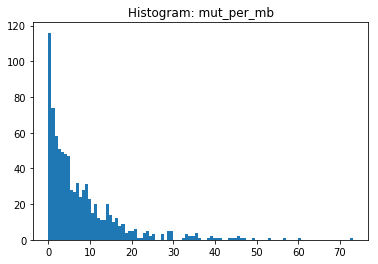

Median mut_per_mb: 4.885714286
Mean mut_per_mb: 7.9441558442587406
Stdev mut_per_mb: 9.203017358482045
Min mut_per_mb: 0.0
Max mut_per_mb: 73.08571429


In [17]:
# Label distribution: mutations per megabase (mut_per_mb)
plt.hist(df['mut_per_mb'], bins=100)
plt.title("Histogram: mut_per_mb")
plt.show()
print("Median mut_per_mb: {}".format(np.median(df['mut_per_mb'])))
print("Mean mut_per_mb: {}".format(np.mean(df['mut_per_mb'])))
print("Stdev mut_per_mb: {}".format(np.std(df['mut_per_mb'])))
print("Min mut_per_mb: {}".format(np.min(df['mut_per_mb'])))
print("Max mut_per_mb: {}".format(np.max(df['mut_per_mb'])))

How many patients in the dataset have a TMB of 0?

In [18]:
print(len(df[df['mut_per_mb']==0]))

4


How many patients in the dataset have no mutations in any of the 9 genomic regions in our feature set?

In [19]:
df_training_nonzero = df_training[(df_training.T != 0).any()]
print(len(df_training) - len(df_training_nonzero))

183


Of those 183 patients in our dataset who have no mutations in any of the 9 genes in our feature set, what is the distribution of their TMBs?

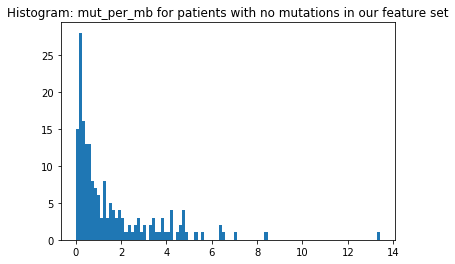

Median mut_per_mb: 0.8
Mean mut_per_mb: 1.5509758001803278
Stdev mut_per_mb: 1.8762842585480481
Min mut_per_mb: 0.0
Max mut_per_mb: 13.42857143


In [20]:
# Get the sub-dataframe where all feature genes have 0 mutations.
df_zeros = df[(df['nmut_TTN']==0) & (df['nmut_LRP1B']==0) & (df['nmut_CSMD3']==0) & (df['nmut_PAPPA2']==0) & 
             (df['nmut_TP53']==0) & (df['nmut_EGFR']==0) & (df['nmut_KRAS']==0) & 
             (df['nmut_EGFR_exons18to21']==0) & (df['nmut_KRAS_hotspots']==0)]

# Label distribution: mutations per mb
plt.hist(df_zeros['mut_per_mb'], bins=100)
plt.title("Histogram: mut_per_mb for patients with no mutations in our feature set")
plt.show()
print("Median mut_per_mb: {}".format(np.median(df_zeros['mut_per_mb'])))
print("Mean mut_per_mb: {}".format(np.mean(df_zeros['mut_per_mb'])))
print("Stdev mut_per_mb: {}".format(np.std(df_zeros['mut_per_mb'])))
print("Min mut_per_mb: {}".format(np.min(df_zeros['mut_per_mb'])))
print("Max mut_per_mb: {}".format(np.max(df_zeros['mut_per_mb'])))

As we'd expect, cases with no mutations in any of the 9 feature genomic regions have lower median and mean TMBs.  However, we see from the max that there is at least one case with a high TMB and no mutations in our 9 feature genes.  Let's find that case(s):

In [22]:
df_zeros.loc[df_zeros['binary_label'] == 'HIGH']

,name,ttype,nmut,mut_per_mb,binary_label,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots
696,TCGA-44-2657,LUAD,470,13.428571,HIGH,0,0,0,0,0,0,0,0,0


Below, we plot the distributions for each of our features (i.e. the distribution of number of mutations per case found in each of the 9 genomic regions, with summary statistics beneath the graphs).

In [24]:
feature_column_names = ['nmut_TTN',
       'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR',
       'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']

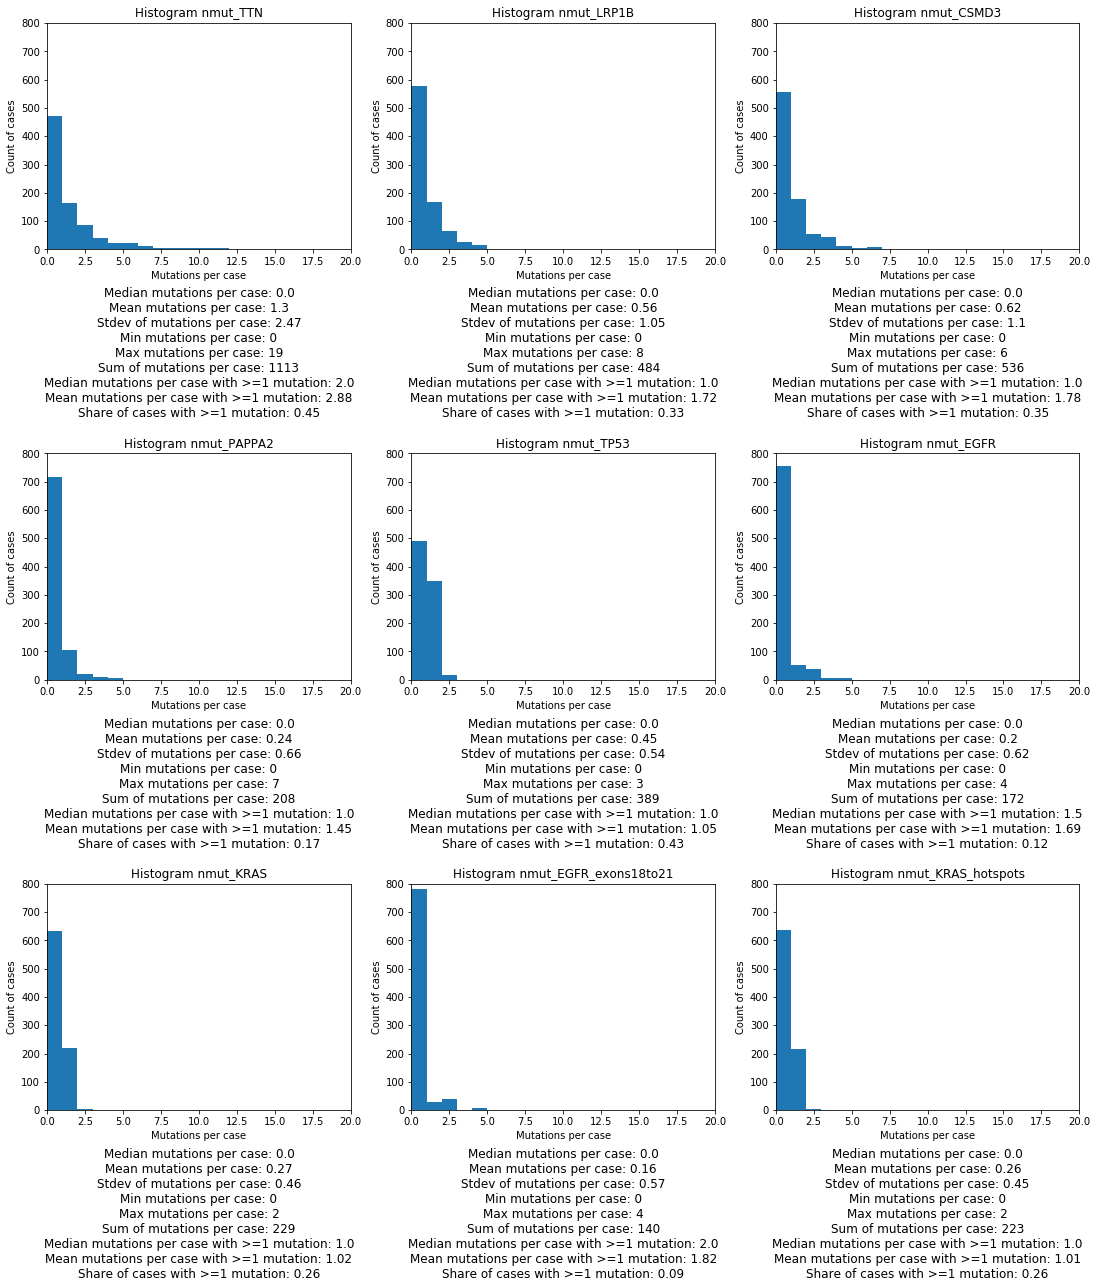

In [25]:
import matplotlib.pyplot as plt

x = range(10)
y = range(10)

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.subplots_adjust(hspace=0.9)
fig.set_size_inches(18.5, 20)

i = 0
for row in ax:
    for col in row:
        col.hist(df[feature_column_names[i]], bins=np.arange(0,20,1))
        col.set_title("Histogram {}".format(feature_column_names[i]))
        col.set_xlim([0, 20])
        col.set_ylim([0, 800])
        col.set_xlabel("Mutations per case")
        col.set_ylabel("Count of cases")
        col.axis('on')
        
        median_mut = round(np.median(df[feature_column_names[i]]),2)
        median_text = "Median mutations per case: {}".format(median_mut)        
        
        mean_mut = round(np.mean(df[feature_column_names[i]]),2)
        mean_text = "Mean mutations per case: {}".format(mean_mut)
        
        # Get all cases with at least one mutation for the current gene
        mut = df[feature_column_names[i]]
        
        median_mut_nonzero = round(np.median(mut[mut > 0]),2)
        median_text_nonzero = "Median mutations per case with >=1 mutation: {}".format(median_mut_nonzero)        
        
        mean_mut_nonzero = round(np.mean(mut[mut > 0]),2)
        mean_text_nonzero = "Mean mutations per case with >=1 mutation: {}".format(mean_mut_nonzero) 
        
        total_cases_nonzero_share = round(float(len(mut[mut>0]))/float(len(mut)),2)
        total_text_nonzero_share = "Share of cases with >=1 mutation: {}".format(total_cases_nonzero_share)
        
        std_mut = round(np.std(df[feature_column_names[i]]),2)
        std_text = "Stdev of mutations per case: {}".format(std_mut)
        
        min_mut = round(np.min(df[feature_column_names[i]]),2)
        min_text = "Min mutations per case: {}".format(min_mut)
        
        max_mut = round(np.max(df[feature_column_names[i]]),2)
        max_text = "Max mutations per case: {}".format(max_mut)
        
        total_mut = round(np.sum(df[feature_column_names[i]]),2)
        total_text = "Sum of mutations per case: {}".format(total_mut)        
        
        col.text(0.5,-0.1, "\n" + median_text + "\n" + mean_text + "\n" + std_text + "\n" + min_text + 
                 "\n" + max_text + "\n" + total_text + "\n" + median_text_nonzero + "\n" + mean_text_nonzero
                 + "\n" + total_text_nonzero_share,
                 size=12, ha="center", va="top", transform=col.transAxes)
        
        i += 1

        
plt.show()

Findings from above:
- Every feature (genomic region) has a median mutation count per case of 0.
- TTN dominates the dataset; it accounts for twice as many mutations as any other genomic region and has at least one mutation in 45% of cases (though TP53 is not far behind on that metric, with at least one mutation in 43% of cases).  When it is mutated, it has the highest mean and median mutation count of any gene in the dataset.

This raises the question: what is the distribution of total mutations (i.e. summing over mutation counts in the 9 feature genes) among our sample set?

In [26]:
# Distribution of total mutations (over 9 feature genes) in our sample population
# First, create a series from summing over the training feature columns
sum_muts = df_training.apply(lambda row: sum(row), axis=1)

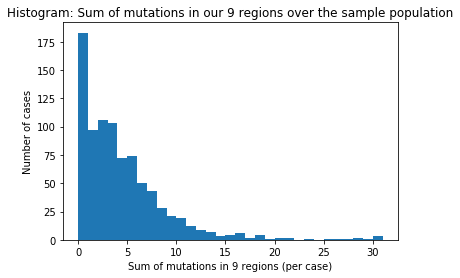

Median number of mutations over 9 regions: 3.0
Mean number of mutations over 9 regions: 4.072261072261072
Stdev of number of mutations over 9 regions: 4.603576168107885
Min number of mutations over 9 regions: 0
Max number of mutations over 9 regions: 31


In [27]:
plt.hist(sum_muts, bins=np.arange(0,max(sum_muts)+1,1))
plt.title("Histogram: Sum of mutations in our 9 regions over the sample population")
plt.xlabel("Sum of mutations in 9 regions (per case)")
plt.ylabel("Number of cases")
plt.show()
print("Median number of mutations over 9 regions: {}".format(np.median(sum_muts)))
print("Mean number of mutations over 9 regions: {}".format(np.mean(sum_muts)))
print("Stdev of number of mutations over 9 regions: {}".format(np.std(sum_muts)))
print("Min number of mutations over 9 regions: {}".format(np.min(sum_muts)))
print("Max number of mutations over 9 regions: {}".format(np.max(sum_muts)))

The histogram above is roughly as expected.  Next, let's plot the *percentage* of cases at a given mutational load (over the 9 genes in our dataset).  The x-axis will remain the same, and the y-axis will be "% of cases with high TMB.

In [29]:
# First we need to set up the data for our plot.  We'll do this by first adding a columns to df: sum_muts (as above).
df['sum_muts'] = df_training.apply(lambda row: sum(row), axis=1)

In [30]:
# Now, we need to use group by to map distinct sum_muts values to the number of HIGH cases...
sum_muts_series_HIGH = df.groupby(['sum_muts'])["binary_label"].apply(lambda x: x[x == 'HIGH'].count())

In [31]:
# Left column is mutations per case; right column is count of cases with high TMB.
sum_muts_series_HIGH

sum_muts
0      1
1      4
2     10
3     16
4     20
5     20
6     18
7     29
8     21
9     16
10    12
11    12
12     8
13     7
14     3
15     4
16     6
17     2
18     4
19     1
20     2
21     2
23     1
25     1
26     1
27     1
28     2
29     1
30     1
31     2
Name: binary_label, dtype: int64

In [32]:
# Next we need to get a corresponding series with totals
sum_muts_series_TOTAL = df.groupby(['sum_muts'])["binary_label"].count()

In [33]:
sum_muts_series_TOTAL

sum_muts
0     183
1      97
2     106
3     103
4      72
5      74
6      50
7      43
8      28
9      21
10     19
11     12
12      9
13      7
14      3
15      4
16      6
17      2
18      4
19      1
20      2
21      2
23      1
25      1
26      1
27      1
28      2
29      1
30      1
31      2
Name: binary_label, dtype: int64

In [35]:
sum_muts_series_FINAL = sum_muts_series_HIGH / sum_muts_series_TOTAL

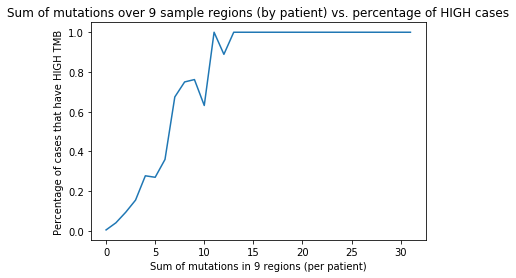

In [36]:
plt.plot(sum_muts_series_FINAL)
plt.title("Sum of mutations over 9 sample regions (by patient) vs. percentage of HIGH cases")
plt.xlabel("Sum of mutations in 9 regions (per patient)")
plt.ylabel("Percentage of cases that have HIGH TMB")
plt.show()

As we'd expect, the percentage of cases with high TMB generally increases as the sum of mutations over the nine sample genes increases.  However, recall that high/low TMB is a human-defined cutoff; with that in mind, let's create a scatter plot of "Sum of mutations.." vs. mut_per_mb:

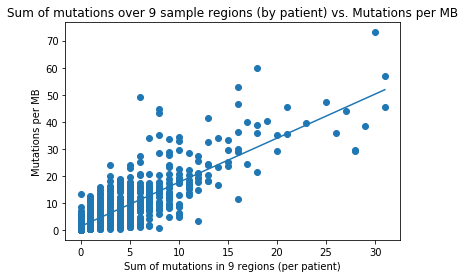

R_squared: 0.6653211908008703


In [39]:
plt.scatter(df['sum_muts'], df['mut_per_mb'])
plt.plot(np.unique(df['sum_muts']), np.poly1d(np.polyfit(df['sum_muts'], df['mut_per_mb'], 1))\
         (np.unique(df['sum_muts'])))
plt.title("Sum of mutations over 9 sample regions (by patient) vs. Mutations per MB")
plt.xlabel("Sum of mutations in 9 regions (per patient)")
plt.ylabel("Mutations per MB")
plt.show()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['sum_muts'], df['mut_per_mb'])
print("R_squared: {}".format(r_value**2))

Again, the results seems reasonable: there's a positive correlation between the sum of mutations per patient in those 9 sample regions, and the overall TMB.  We add in the line of best fit to eliminate the possiblity of eyeballing error for the mass concentrated in the lower left quadrant.

Now that we have our distributions for each of the feature columns, let's create covariance and correlation matrices for our feature genes:

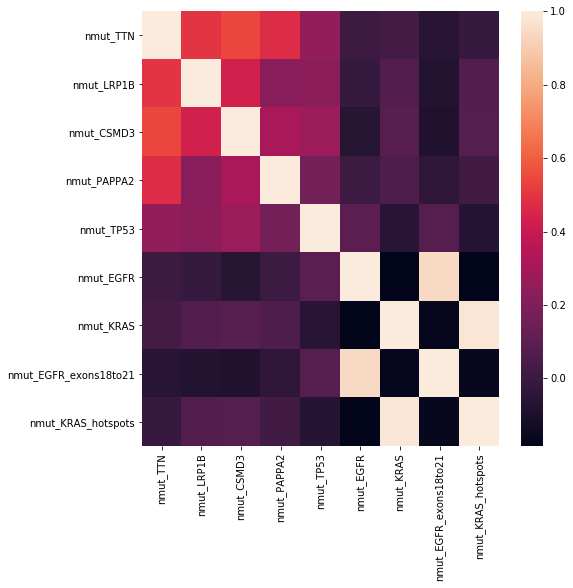

In [40]:
# Correlation matrix
a4_dims = (8,8)
fig, ax = plt.subplots(figsize=a4_dims)
corr = df_training.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

We see above that nmut_EGFR and nmut_EGFR_exons18to21 are highly correlated, as are nmut_KRAS and nmut_KRAS_hotspots; both of these results are of course expected.  Otherwise, we see fairly low correlations between features.  nmut_TTN is moderately correlated with nmut_LRP1B, nmut_CSMD3, and nmut_PAPPA2.  nmut_LRP1B is moderately correlated with nmut_CSMD3.  Apart from these, there are no notable correlations among features.

Interestingly, there are some relatively weak negative correlations involving EGFR and KRAS.

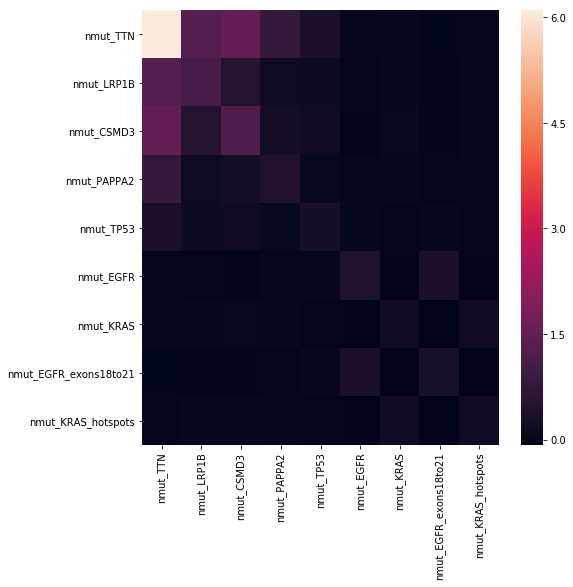

In [41]:
# Covariance matrix
a4_dims = (8,8)
fig, ax = plt.subplots(figsize=a4_dims)
cov = df_training.cov()
sns.heatmap(cov, 
            xticklabels=cov.columns.values,
            yticklabels=cov.columns.values)

In the covariance matrix above, we note a moderately positive relation betweet nmut_TTN and each of nmut_LRP1B, nmut_CSMD3, and nmut_PAPPA2.  Recall that those four variants also have the highest variance overall, and they also have the highest mutational loads of all genes in the dataset.

We also note that in the covariance matrix, the elements on the diagonal represent the overall variances of the given feature (which is why the diagonal is not uniform).  E.g. nmut_TTN has by far the highest variance, just as we observed when plotting the distributions of our individual features further above.

Next, let's create a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) of all our feature genes, to see if we can spot any trends.

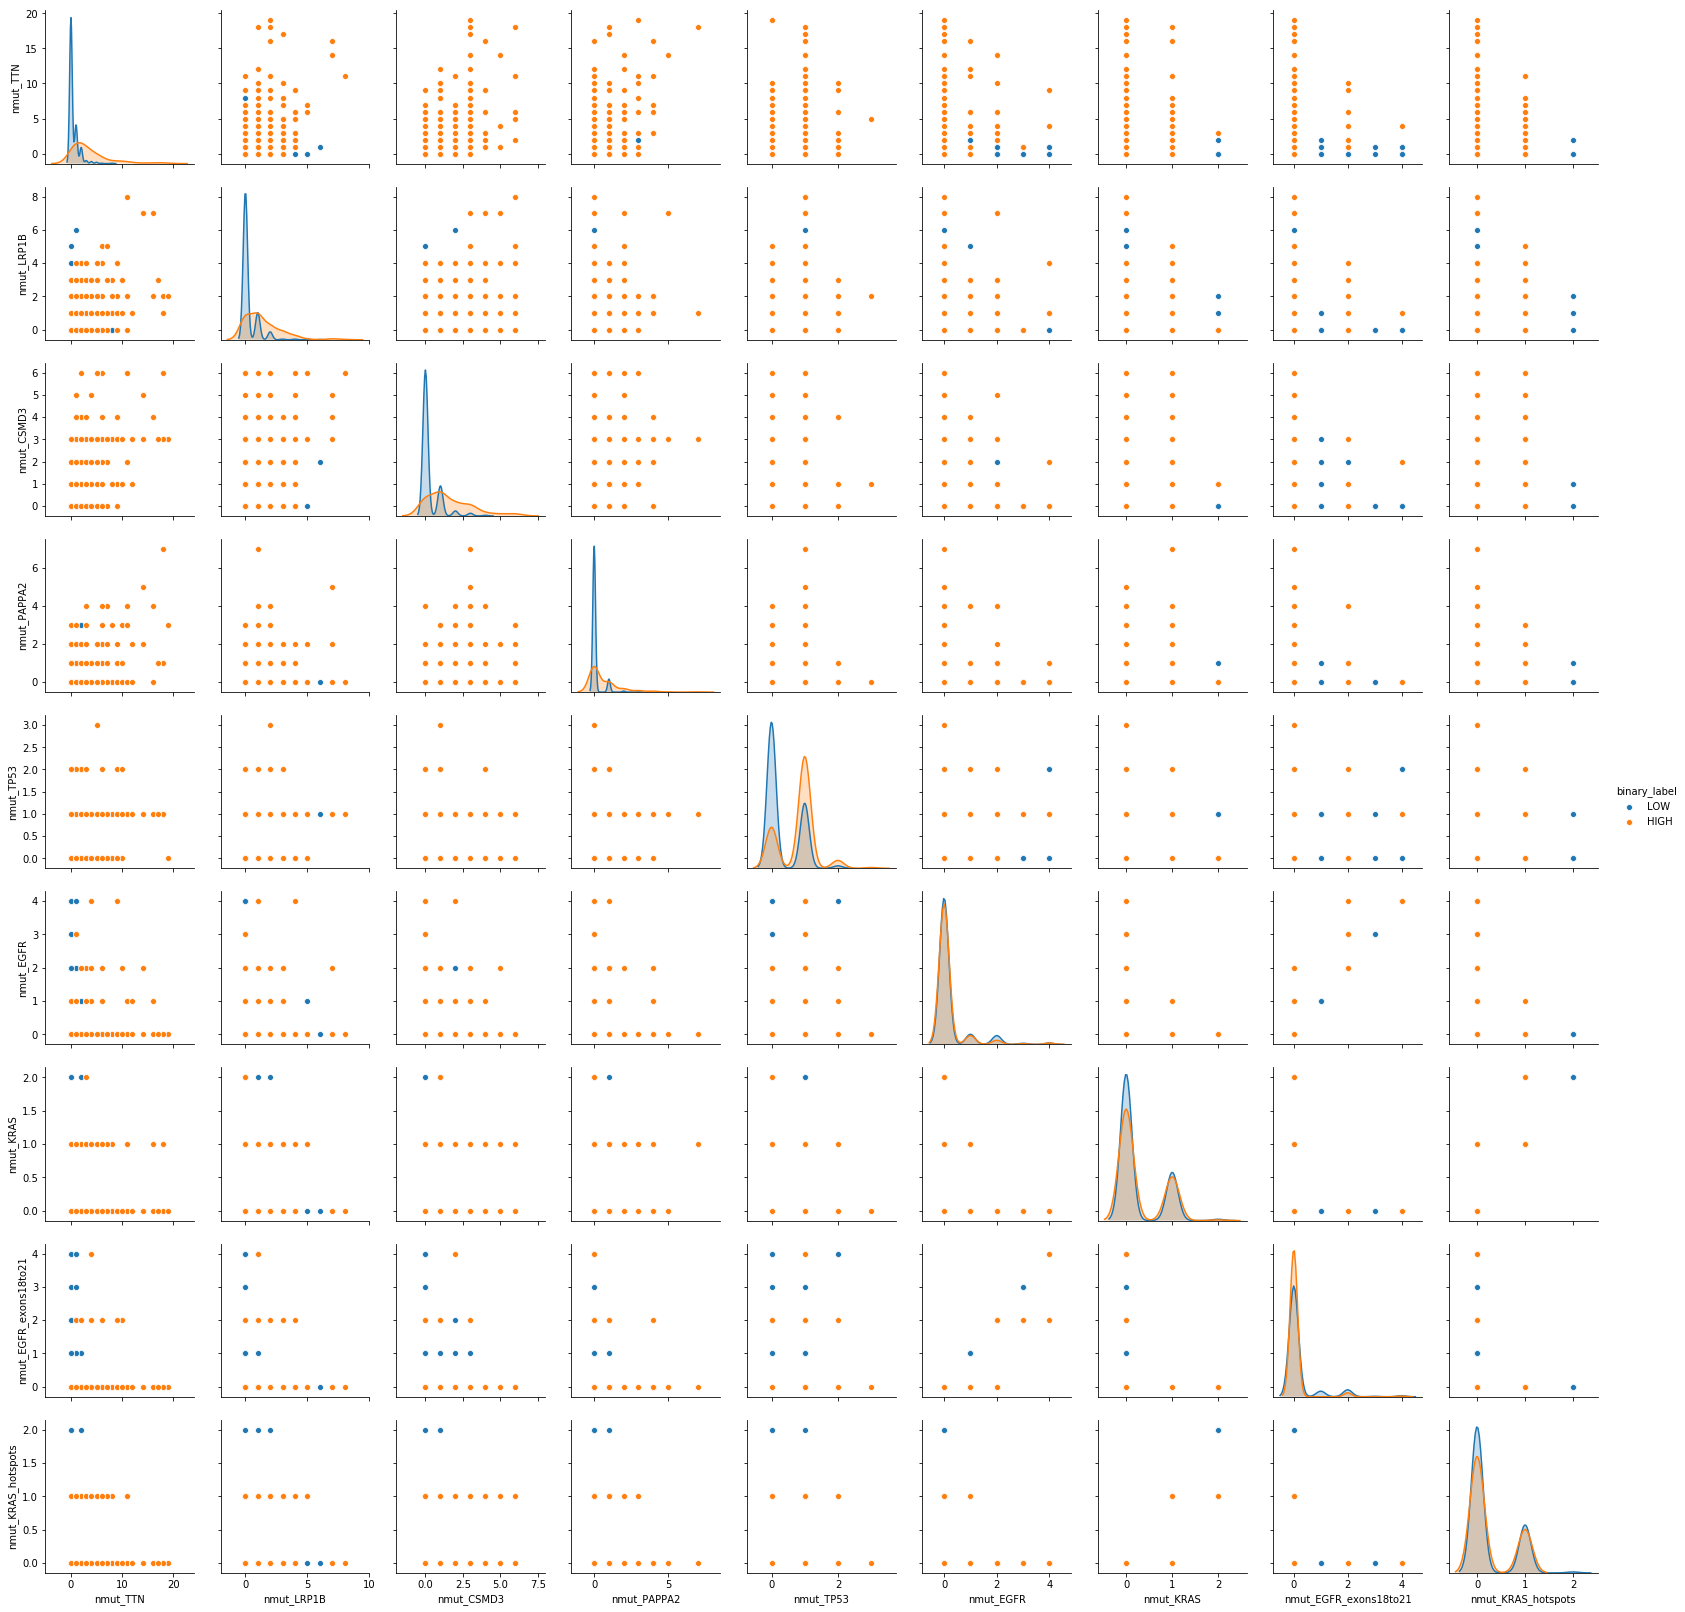

In [44]:
sns.pairplot(df_feats_and_binary_label, hue="binary_label")

Pairplotting is may actually not a good idea here, since the number of mutations in our features is discrete and in a small range, so very large numbers of dots will overlap (it looks like orange/high points mask blue/low dots by default, making it look like there are fewer blue/low cases on each plot than there really are.  That is the opposite of the actual distribution of our dataset, in which 73% of cases are low TMB. Unfortunately, the plotting function has no parameters for alpha or "jiggling" points).

With that said, the diagonal charts are most useful.  For our first five genomic regions, having 0 mutations in the region is disproportionately associated with low TMBs, though for the first four regions, we note that the distribution of high TMB cases seems somewhat invariant to the number of mutations in the given regions (as high cases are relatively infrequent in our dataset overall).  TP53 is the one genomic region where we see clear distinction: having 0 mutations in the regions is clearly associated with low TMB, whereas having 1 mutation is clearly associated with HIGH TMB; there are too few cases with more than one mutations in the region to say anything about.  For our remaining four regions- KRAS, EGFR, and their respective derivatives- there is virtually no distinction between the HIGH and LOW TMB curves: that is to say that the number of mutations in any one of those regions conveys almost no information (in isolation) of a case's likelihood of having a high or low TMB.

Let's look a little closer at TP53, since it is the one region in which mutation count appears to significantly distinguish between HIGH and LOW TMB:

In [47]:
print("Count of patients with no TP53 mutations and low TMB:")
print(len(df_feats_and_binary_label[(df_feats_and_binary_label['nmut_TP53'] == 0) 
                          & (df_feats_and_binary_label['binary_label'] == "LOW")]))

print("Count of patients with no TP53 mutations and high TMB:")
print(len(df_feats_and_binary_label[(df_feats_and_binary_label['nmut_TP53'] == 0) 
                          & (df_feats_and_binary_label['binary_label'] == "HIGH")]))

print("")

print("Count of patients with 1 TP53 mutation and low TMB:")
print(len(df_feats_and_binary_label[(df_feats_and_binary_label['nmut_TP53'] == 1) 
                          & (df_feats_and_binary_label['binary_label'] == "LOW")]))

print("Count of patients with 1 TP53 mutation and high TMB:")
print(len(df_feats_and_binary_label[(df_feats_and_binary_label['nmut_TP53'] == 1) 
                          & (df_feats_and_binary_label['binary_label'] == "HIGH")]))

print("")

print("Count of patients with 2 TP53 mutation and low TMB:")
print(len(df_feats_and_binary_label[(df_feats_and_binary_label['nmut_TP53'] == 2) 
                          & (df_feats_and_binary_label['binary_label'] == "LOW")]))

print("Count of patients with 2 TP53 mutation and high TMB:")
print(len(df_feats_and_binary_label[(df_feats_and_binary_label['nmut_TP53'] == 2) 
                          & (df_feats_and_binary_label['binary_label'] == "HIGH")]))

Count of patients with no TP53 mutations and low TMB:
431
Count of patients with no TP53 mutations and high TMB:
58

Count of patients with 1 TP53 mutation and low TMB:
192
Count of patients with 1 TP53 mutation and high TMB:
158

Count of patients with 2 TP53 mutation and low TMB:
7
Count of patients with 2 TP53 mutation and high TMB:
11


Let's look at the real continuous TMB values now, instead of using the expert-defined low/high cutoff.

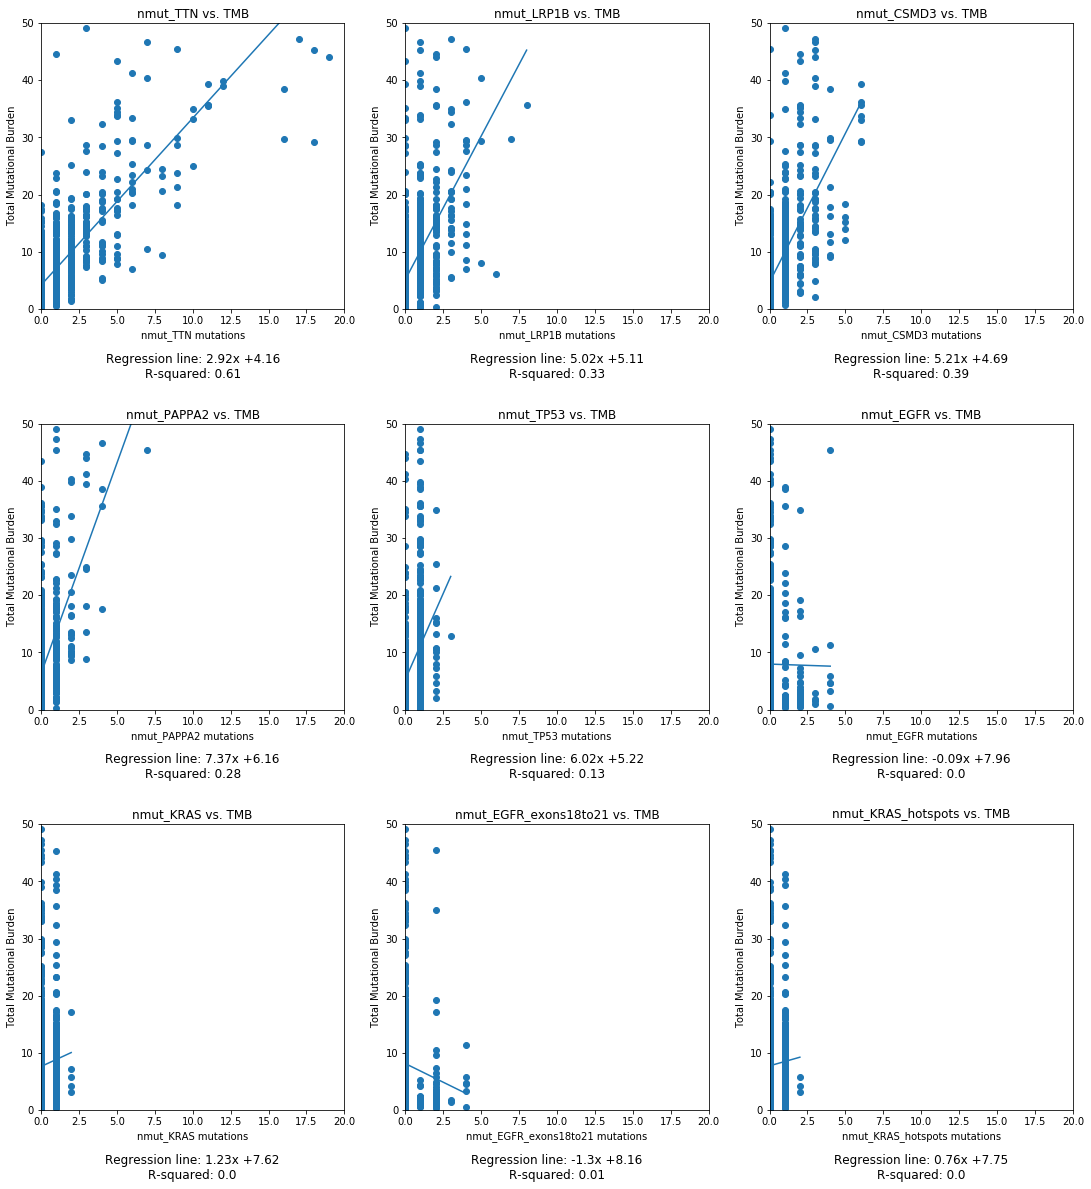

In [50]:
x = range(10)
y = range(10)

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.subplots_adjust(hspace=0.4)
fig.set_size_inches(18.5, 20)

i = 0
for row in ax:
    for col in row:
        x = df[feature_column_names[i]]
        y = df['mut_per_mb']
        col.scatter(x, y)
        col.set_title("{} vs. TMB".format(feature_column_names[i]))
        col.set_xlim([0, 20])
        col.set_ylim([0, 50])
        col.set_xlabel("{} mutations".format(feature_column_names[i]))
        col.set_ylabel("Total Mutational Burden")
        # Line of best fit
        col.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        col.axis('on')
        
#         median_mut = round(np.median(df[feature_column_names[i]]),2)
#         median_text = "Median mutations per case: {}".format(median_mut)        
        
#         mean_mut = round(np.mean(df[feature_column_names[i]]),2)
#         mean_text = "Mean mutations per case: {}".format(mean_mut)
        
#         # Get all cases with at least one mutation for this genomic region
#         mut = df[feature_column_names[i]]
        
#         median_mut_nonzero = round(np.median(mut[mut > 0]),2)
#         median_text_nonzero = "Median mutations per case with >=1 mutation: {}".format(median_mut_nonzero)        
        
#         mean_mut_nonzero = round(np.mean(mut[mut > 0]),2)
#         mean_text_nonzero = "Mean mutations per case with >=1 mutation: {}".format(mean_mut_nonzero) 
        
#         std_mut = round(np.std(df[feature_column_names[i]]),2)
#         std_text = "Stdev of mutations per case: {}".format(std_mut)
        
#         min_mut = round(np.min(df[feature_column_names[i]]),2)
#         min_text = "Min mutations per case: {}".format(min_mut)
        
#         max_mut = round(np.max(df[feature_column_names[i]]),2)
#         max_text = "Max mutations per case: {}".format(max_mut)
        
#         total_mut = round(np.sum(df[feature_column_names[i]]),2)
#         total_text = "Sum of mutations per case: {}".format(total_mut)        
                                                               
#         col.text(0.5,-0.1, "\n" + median_text + "\n" + mean_text + "\n" + std_text + "\n" + min_text + 
#                  "\n" + max_text + "\n" + total_text + "\n" + median_text_nonzero + "\n" + mean_text_nonzero,
#                  size=12, ha="center", va="top", transform=col.transAxes)
        
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

        col.text(0.5, -0.1,"\n" + "Regression line: {}".format(str(round(slope,2))+"x +"+str(round(intercept,2))) \
                 + "\n" + "R-squared: {}".format(round(r_value**2,2)), size=12, ha='center', va='top', transform=col.transAxes)
    
        i += 1

plt.show()

The above plots show that, for most of our feature genes, an increase in their mutational load correlates with an increase in overall TMB.  However, EGFR and EGFR_exons18to21 are an exception (they have negative trendlines, though R squared values indicate almost no explanatory power).  EGFR in particular is nearly flat.

Now that we've done some preliminary feature inspection, let's run a [principal component analysis](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).

In [53]:
# Separating out the features
x = df_training.values

# Separating out the target
y = df_labels.values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [55]:
# Run PCA with two components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [56]:
finalDf = pd.concat([principalDf, df[['binary_label']]], axis = 1)

In [57]:
finalDf.head(5)

,principal component 1,principal component 2,binary_label
0,-1.149117,-0.547086,LOW
1,-1.149117,-0.547086,LOW
2,-1.149117,-0.547086,LOW
3,-1.149117,-0.547086,LOW
4,-1.149117,-0.547086,LOW


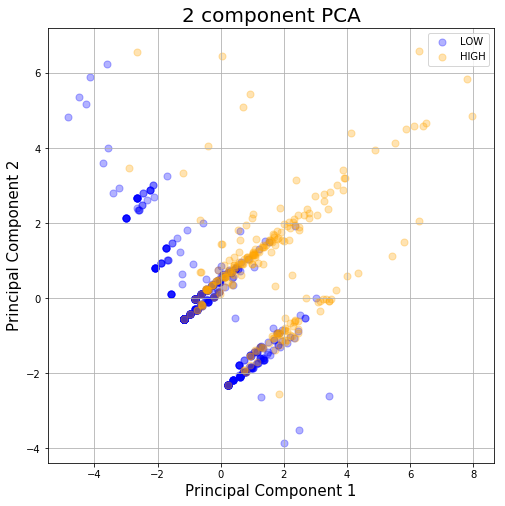

In [60]:
# Plot the results of PCA to see if we it achieved separation of our two label classes

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LOW', 'HIGH']
colors = ['b','orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['binary_label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

Our two label classes look somewhat separable on two principal components, but there's still a lot of noise, especially in the two densest regions (a curve of best fit of reasonably low degree would still miss a lot... **I wonder if it will perform worst on cases near the margin?**).

Let's try sparse PCA, since there is a decent amount of sparsity in our dataset.

In [64]:
sparse_pca = SparsePCA(n_components=2)
sparse_principalComponents = sparse_pca.fit_transform(x)
sparse_principalDf = pd.DataFrame(data = sparse_principalComponents
             , columns = ['sparse principal component 1', 'sparse principal component 2'])

In [65]:
sparse_finalDf = pd.concat([sparse_principalDf, df[['binary_label']]], axis = 1)

In [66]:
sparse_finalDf.head(5)

,sparse principal component 1,sparse principal component 2,binary_label
0,0.026767,0.005725,LOW
1,0.026767,0.005725,LOW
2,0.026767,0.005725,LOW
3,0.026767,0.005725,LOW
4,0.026767,0.005725,LOW


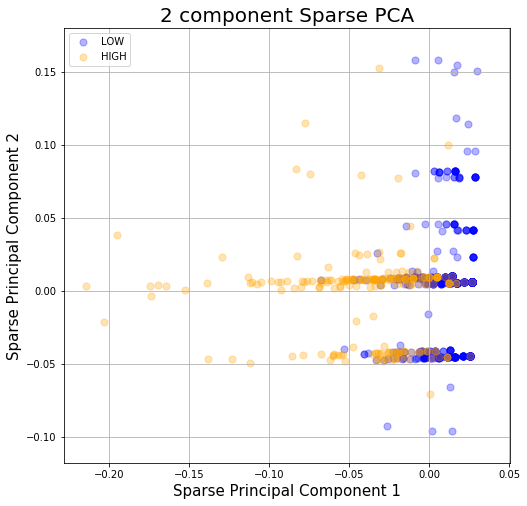

In [68]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Sparse Principal Component 1', fontsize = 15)
ax.set_ylabel('Sparse Principal Component 2', fontsize = 15)
ax.set_title('2 component Sparse PCA', fontsize = 20)
targets = ['LOW', 'HIGH']
colors = ['b','orange']
for target, color in zip(targets,colors):
    indicesToKeep = sparse_finalDf['binary_label'] == target
    ax.scatter(sparse_finalDf.loc[indicesToKeep, 'sparse principal component 1']
               , sparse_finalDf.loc[indicesToKeep, 'sparse principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

Sparse PCA gives a similar result as normal PCA (though shifted)- we can eyeball a line of best fit, but there will still be a lot of noise.

# Model Selection (Cross-Validation)

We've done enough exploratory analysis of our data for now; it's time to proceed with model selection.  We'll start with the binary classification case (high/low) and then move to the continuous case (predicting TMB numeric values).  We begin by writing a few helper functions for use in model selection and evaluation.

In [75]:
# Write a function to calculate specificity (sklearn doesn't have on built in)

def get_specificity(y_true, y_pred):
    true_neg = 0
    # get true negatives
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 0:
            true_neg +=1
    # get condition_neg
    condition_neg = len(y_true) - sum(y_true)
    return float(true_neg) / float(condition_neg)

In [76]:
# Write a helper function for normalization; we'll see if normalization improves
# performance in cross-validation.

def normalize_df_columns(df):
    #x is a numpy array
    x = df.values
    # normalize on (0,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = ['nmut_TTN',
       'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR',
       'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']
    
    return df

Create a normalized version of our training dataset using the function created above:

In [71]:
df_training_normalized = normalize_df_columns(df_training)

In [72]:
df_training_normalized.tail(5)

,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots
853,0.157895,0.000,0.166667,0.142857,0.333333,0.0,0.0,0.0,0.0
854,0.315789,0.125,0.000000,0.571429,0.333333,0.5,0.0,0.5,0.0
855,0.736842,0.875,0.833333,0.285714,0.333333,0.5,0.0,0.0,0.0
856,0.526316,0.375,0.500000,0.142857,0.333333,0.0,0.0,0.0,0.0
857,0.736842,0.875,0.500000,0.714286,0.333333,0.0,0.0,0.0,0.0


We'll use cross validation for model selection instead of a single train-test split in order to take full advantage of our dataset.  To start, we won't use normalization; we'll add it in later and see if performance improves.

In [124]:
def run_cross_validation(X, y, model, use_weighting, n_folds=5):

    # Initialize lists to store evaluation metrics for each cv fold
    aucs = []
    roc_plots = []
    conf_mats = []
    precisions = []
    # recall is the same as sensitivity
    recalls = []
    specs = []
    f1s = []

    # We don't set a random state, because we'll want to do bootstrapping later
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

    # Weighting variables (if use_weighting = True)
    # TO DO: Allow user to specify custom class-weights
    low_weight = float(sum(y)[0])/float(len(y))
    high_weight = 1.0 - low_weight
    weight_dict = {0:low_weight, 1:high_weight}
    
    for train_index, test_index in skf.split(X, y):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if use_weighting:
            model.class_weight=weight_dict
        
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        # Note: we restrict ourself to classification algorithms that also output label probabilities
        probs = model.predict_proba(X_test)
        pos_probs = [row[1] for row in probs]

        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        specificity = get_specificity(y_test, preds) 
        f1 = f1_score(y_test, preds)

        precisions.append(precision)
        recalls.append(recall)
        specs.append(specificity)
        f1s.append(f1)

        cm = confusion_matrix(y_test, preds)
        roc_plot = roc_curve(y_test, pos_probs)
        auc = roc_auc_score(y_test, pos_probs)

        conf_mats.append(cm)
        roc_plots.append(roc_plot)
        aucs.append(auc)
        
    # return a tuple of the mean auc, precision recall/sensitivity, specificity, and f1 score
    return (np.mean(aucs), np.mean(precisions), np.mean(recalls), np.mean(specs), np.mean(f1s))
    
    

In [73]:
# Convert dfs to numpy arrays
X = df_training.values

# Get our binary (high/low) labels
y = df_labels.values

# Get our continuous TMB labels
y_continuous = df['nmut'].values

Set up for stratified k-fold cross validation. Use 5 folds (10 seems excessive; we have less than 1000 rows and want to stay above 100 rows per fold). Note: it is **crucial** that we shuffle our data, as our input data is ordered (from lowest to highest TMB).

In [125]:
# Write a tuple of names to correspond with our results from above:
cv_names_tup = ('Mean AUC', 'Mean precision', 'Mean recall', 'Mean specificity', 'Mean F1')

We'll start model selection with logistic regression.  Initialize a logistic regression classifier with default hyperparameters and test out the cross validation function.

In [126]:
lrc = LogisticRegression()

In [128]:
result_tup = run_cross_validation(X, y, lrc, False)

In [129]:
print(*zip(cv_names_tup, result_tup))

('Mean AUC', 0.9305402193083353) ('Mean precision', 0.7130555728013355) ('Mean recall', 0.8288888888888888) ('Mean specificity', 0.8777777777777777) ('Mean F1', 0.7648396697299062)


Now, write a function to run [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics).  Bootstrapping will be useful for creating confidence intervals around our evaluation metrics, given the relatively small number of instances in our dataset.  Specifically, it will run multiple iterations of cross validation (as specified by the num_bs_rounds parameter; we'll still use 5-fold cv).

In [117]:
def get_bootstrap_CIs(X, y, model, use_weighting, num_bs_rounds=1000, num_cv_folds=5):
    
    # Initialized our evaluation metric lists for bootstrapping
    bs_aucs = []
    bs_precisions = []
    # recall == sensitivity
    bs_recalls = []
    bs_specs = []
    bs_f1s = []
    
    # Do the bootstrapping and append the results
    for i in range(num_bs_rounds):
        # Each round of bootstrapping == a run of 5-fold cross validation
        result_tup = run_cross_validation(X, y, model, use_weighting, num_cv_folds)
        bs_aucs.append(result_tup[0])
        bs_precisions.append(result_tup[1])
        bs_recalls.append(result_tup[2])
        bs_specs.append(result_tup[3])
        bs_f1s.append(result_tup[4])
        
        if i%100 == 0:
            print("Finished {} rounds of bootstrapping out of {}".format(i, num_bs_rounds))
    print()
    
    # For each evaluation metric list, we sort the contents in order to get percentiles.
    # Note that we use 95% confidence intervals below.
    sorted_bs_aucs = np.array(bs_aucs)
    sorted_bs_aucs.sort()
    auc_ci_lower = sorted_bs_aucs[int(0.05 * len(sorted_bs_aucs))]
    auc_ci_upper = sorted_bs_aucs[int(0.95 * len(sorted_bs_aucs))]
    auc_ci = (auc_ci_lower, auc_ci_upper)
    
    sorted_bs_precisions = np.array(bs_precisions)
    sorted_bs_precisions.sort()
    precision_ci_lower = sorted_bs_precisions[int(0.05 * len(sorted_bs_precisions))]
    precision_ci_upper = sorted_bs_precisions[int(0.95 * len(sorted_bs_precisions))]
    precision_ci = (precision_ci_lower, precision_ci_upper)
    
    sorted_bs_recalls = np.array(bs_recalls)
    sorted_bs_recalls.sort()
    recall_ci_lower = sorted_bs_recalls[int(0.05 * len(sorted_bs_recalls))]
    recall_ci_upper = sorted_bs_recalls[int(0.95 * len(sorted_bs_recalls))]
    recall_ci = (recall_ci_lower, recall_ci_upper)
    
    sorted_bs_specs = np.array(bs_specs)
    sorted_bs_specs.sort()
    spec_ci_lower = sorted_bs_specs[int(0.05 * len(sorted_bs_specs))]
    spec_ci_upper = sorted_bs_specs[int(0.95 * len(sorted_bs_specs))]
    spec_ci = (spec_ci_lower, spec_ci_upper)
    
    sorted_bs_f1s = np.array(bs_f1s)
    sorted_bs_f1s.sort()
    f1s_ci_lower = sorted_bs_f1s[int(0.05 * len(sorted_bs_f1s))]
    f1s_ci_upper = sorted_bs_f1s[int(0.95 * len(sorted_bs_f1s))]
    f1_ci = (f1s_ci_lower, f1s_ci_upper)
    
    print("Mean AUC is: {}".format(np.mean(bs_aucs)))
    print("Mean Precision is: {}".format(np.mean(bs_precisions)))
    print("Mean Recall/Sensitivity is: {}".format(np.mean(bs_recalls)))
    print("Mean Specificity is: {}".format(np.mean(bs_specs)))
    print("Mean F1 Score is: {}".format(np.mean(bs_f1s)))
    print("")
    print("95% AUC Confidence Interval is: {}".format(auc_ci))
    print("95% Precision Confidence Interval is: {}".format(precision_ci))
    print("95% Recall/Sensitivity Confidence Interval is: {}".format(recall_ci))
    print("95% Specificity Confidence Interval is: {}".format(spec_ci))
    print("95% F1 Score Interval is: {}".format(f1_ci))
    
    return [auc_ci, precision_ci, recall_ci, spec_ci, f1_ci]

#TODO: Apply multi-processing to make bootstrapping run faster

Get 95% Confidence Intervals for a Logistic Regression Classifier with default hyperparameters:

In [118]:
lrc_cis = get_bootstrap_CIs(X, y, lrc, use_weighting=False, num_bs_rounds=1000, num_cv_folds=5)

Finished 0 rounds of bootstrapping out of 1000
Finished 100 rounds of bootstrapping out of 1000
Finished 200 rounds of bootstrapping out of 1000
Finished 300 rounds of bootstrapping out of 1000
Finished 400 rounds of bootstrapping out of 1000
Finished 500 rounds of bootstrapping out of 1000
Finished 600 rounds of bootstrapping out of 1000
Finished 700 rounds of bootstrapping out of 1000
Finished 800 rounds of bootstrapping out of 1000
Finished 900 rounds of bootstrapping out of 1000

Mean AUC is: 0.9310466451959205
Mean Precision is: 0.7070456245591715
Mean Recall/Sensitivity is: 0.8291691787439613
Mean Specificity is: 0.8737174603174604
Mean F1 Score is: 0.7615123045665755

95% AUC Confidence Interval is: (0.9281515988037728, 0.9335802469135803)
95% Precision Confidence Interval is: (0.6938465041188889, 0.71919329012581)
95% Recall/Sensitivity Confidence Interval is: (0.8117874396135267, 0.842415458937198)
95% Specificity Confidence Interval is: (0.8666666666666666, 0.880952380952381)

In [119]:
# Next, let's check if weighting the classes inversely to their frequencies improves performance.

lrc_cis = get_bootstrap_CIs(X, y, LogisticRegression(), use_weighting=True,
                            num_bs_rounds=1000, num_cv_folds=5)

Finished 0 rounds of bootstrapping out of 1000
Finished 100 rounds of bootstrapping out of 1000
Finished 200 rounds of bootstrapping out of 1000
Finished 300 rounds of bootstrapping out of 1000
Finished 400 rounds of bootstrapping out of 1000
Finished 500 rounds of bootstrapping out of 1000
Finished 600 rounds of bootstrapping out of 1000
Finished 700 rounds of bootstrapping out of 1000
Finished 800 rounds of bootstrapping out of 1000
Finished 900 rounds of bootstrapping out of 1000

Mean AUC is: 0.9311030108887355
Mean Precision is: 0.7071829893380521
Mean Recall/Sensitivity is: 0.8284891787439612
Mean Specificity is: 0.873925396825397
Mean F1 Score is: 0.7613086244690853

95% AUC Confidence Interval is: (0.9280879533778084, 0.9336373744344758)
95% Precision Confidence Interval is: (0.6937871348509647, 0.7199192243592083)
95% Recall/Sensitivity Confidence Interval is: (0.8117874396135267, 0.842512077294686)
95% Specificity Confidence Interval is: (0.8666666666666666, 0.880952380952381

Custom class weighting had little impact, so we'll forgo it.

Now, let's normalize our training dataset and see if performance improves

In [153]:
#Convert dfs to numpy arrays
X_normalized = df_training_normalized.values

In [154]:
lrc_cis_normalized = get_bootstrap_CIs(X_normalized, y, LogisticRegression(), use_weighting=False, num_bs_rounds=1000)

Finished 0 rounds of bootstrapping out of 1000
Finished 100 rounds of bootstrapping out of 1000
Finished 200 rounds of bootstrapping out of 1000
Finished 300 rounds of bootstrapping out of 1000
Finished 400 rounds of bootstrapping out of 1000
Finished 500 rounds of bootstrapping out of 1000
Finished 600 rounds of bootstrapping out of 1000
Finished 700 rounds of bootstrapping out of 1000
Finished 800 rounds of bootstrapping out of 1000
Finished 900 rounds of bootstrapping out of 1000

Mean AUC is: 0.923711051299747
Mean Precision is: 0.8646815491878235
Mean Recall/Sensitivity is: 0.5707266666666667
Mean Specificity is: 0.9668507936507936
Mean F1 Score is: 0.6846680779518143

95% AUC Confidence Interval is: (0.9210451652480638, 0.9261433172302738)
95% Precision Confidence Interval is: (0.8510740872031194, 0.8788460971433107)
95% Recall/Sensitivity Confidence Interval is: (0.5570048309178743, 0.5835748792270532)
95% Specificity Confidence Interval is: (0.9634920634920634, 0.96984126984127

Normalizing the training set hurt AUC, Recall/Sensitivity, and F1 score, but helped precision and specificy.  Since AUC and F1 score are aggregate metrics, we'll prioritize them and thus proceed without normalizing our training data.

Does standard scaling (removing the mean and scaling to unit variance) yield a better result than standard scaling? Let's try it:

In [155]:
def standardize_df_columns(df):
    #x is a numpy array
    x = df.values
    # normalize on (0,1)
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = ['nmut_TTN',
       'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR',
       'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']
    
    return df

In [156]:
df_training_standardized = standardize_df_columns(df_training)

In [136]:
X_standardized = df_training_standardized.values

In [138]:
lrc_cis_standardized = get_bootstrap_CIs(X_standardized, y, lrc, use_weighting=False, num_bs_rounds=1000)

Finished 0 rounds of bootstrapping out of 1000
Finished 100 rounds of bootstrapping out of 1000
Finished 200 rounds of bootstrapping out of 1000
Finished 300 rounds of bootstrapping out of 1000
Finished 400 rounds of bootstrapping out of 1000
Finished 500 rounds of bootstrapping out of 1000
Finished 600 rounds of bootstrapping out of 1000
Finished 700 rounds of bootstrapping out of 1000
Finished 800 rounds of bootstrapping out of 1000
Finished 900 rounds of bootstrapping out of 1000

Mean AUC is: 0.93028397208803
Mean Precision is: 0.712651894169219
Mean Recall/Sensitivity is: 0.8149751690821256
Mean Specificity is: 0.8790825396825398
Mean F1 Score is: 0.7585992029829314

95% AUC Confidence Interval is: (0.9271179357411242, 0.933016639828234)
95% Precision Confidence Interval is: (0.6984761013158579, 0.7261732192390985)
95% Recall/Sensitivity Confidence Interval is: (0.802415458937198, 0.828985507246377)
95% Specificity Confidence Interval is: (0.8714285714285713, 0.8873015873015874)
9

Standard scaling did not give any improvement, so we'll forgo it.

Let's see if we can get better performance out of a more complex algorithm- gradient boosted decision trees (using the [XGBoost library](http://xgboost.readthedocs.io)).

In [140]:
# Retrospective note: we tried several variations of XGB classifiers; none has matched simple logistic regression on AUC or F1
# xgb_1 = XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=10)

# Start with an xgb classifier with default hyperparameter settings
xgb_1 = XGBClassifier()

In [144]:
# xgb is slower to train and evaluate, so we'll drop down to 100 rounds of bootstrapping
xgb_1_cis = get_bootstrap_CIs(X, y, xgb_1, use_weighting=False, num_bs_rounds=100)

Finished 0 rounds of bootstrapping out of 100

Mean AUC is: 0.9278996932750556
Mean Precision is: 0.7768331032858073
Mean Recall/Sensitivity is: 0.6827700483091786
Mean Specificity is: 0.9276507936507936
Mean F1 Score is: 0.7244674315271794

95% AUC Confidence Interval is: (0.923017406640595, 0.93263591749099)
95% Precision Confidence Interval is: (0.7563013338013338, 0.7978304835447693)
95% Recall/Sensitivity Confidence Interval is: (0.6625120772946861, 0.7022222222222222)
95% Specificity Confidence Interval is: (0.919047619047619, 0.9380952380952381)
95% F1 Score Interval is: (0.708922717189691, 0.744187625205313)


Interesting: xgb's performance is slightly worse than Logistic Regression.  Though keep in mind, we haven't done any hyperparameter optmization. Does normalization help XGBoost?

In [145]:
xgb_1_cis_normalized = get_bootstrap_CIs(X_normalized, y, xgb_1, use_weighting=True, num_bs_rounds=100)

Finished 0 rounds of bootstrapping out of 100

Mean AUC is: 0.9279980254581705
Mean Precision is: 0.7780982418582464
Mean Recall/Sensitivity is: 0.6835971014492753
Mean Specificity is: 0.927984126984127
Mean F1 Score is: 0.7253513206914151

95% AUC Confidence Interval is: (0.9230220075147612, 0.9322778161183958)
95% Precision Confidence Interval is: (0.7606281500688762, 0.7973837019241734)
95% Recall/Sensitivity Confidence Interval is: (0.666280193236715, 0.7058937198067633)
95% Specificity Confidence Interval is: (0.9206349206349207, 0.9349206349206348)
95% F1 Score Interval is: (0.7102346672934908, 0.742276279470015)


Normalization basically didn't move the needle on XGBoost at all.  Let's try standardization:

In [146]:
xgb_1_cis_standardized = get_bootstrap_CIs(X_standardized, y, xgb_1, use_weighting=True, num_bs_rounds=100)

Finished 0 rounds of bootstrapping out of 100

Mean AUC is: 0.9281887316923548
Mean Precision is: 0.7814009232731572
Mean Recall/Sensitivity is: 0.6824637681159422
Mean Specificity is: 0.9294444444444445
Mean F1 Score is: 0.7261491026155916

95% AUC Confidence Interval is: (0.9239494670654091, 0.9320504562533548)
95% Precision Confidence Interval is: (0.7602074677131887, 0.8000212255444813)
95% Recall/Sensitivity Confidence Interval is: (0.6581642512077295, 0.7060869565217391)
95% Specificity Confidence Interval is: (0.9222222222222222, 0.9365079365079365)
95% F1 Score Interval is: (0.706624649859944, 0.7455035012646449)


Standardization also had basically no effect for XGBoost.  Let's not forget to try class weighting:

In [147]:
xgb_1_cis = get_bootstrap_CIs(X, y, xgb_1, use_weighting=True, num_bs_rounds=100)

Finished 0 rounds of bootstrapping out of 100

Mean AUC is: 0.9286013495897556
Mean Precision is: 0.7801099613210768
Mean Recall/Sensitivity is: 0.6838231884057973
Mean Specificity is: 0.9289047619047621
Mean F1 Score is: 0.7265198046460085

95% AUC Confidence Interval is: (0.923039260792884, 0.933668430335097)
95% Precision Confidence Interval is: (0.764485662065923, 0.8042940331802022)
95% Recall/Sensitivity Confidence Interval is: (0.6659903381642512, 0.7021256038647342)
95% Specificity Confidence Interval is: (0.9222222222222222, 0.938095238095238)
95% F1 Score Interval is: (0.7094305937687331, 0.7439754937709627)


Class weighting didn't make a difference either.  Let's search over a few different hyperparameter configurations, starting with tree depth:

In [150]:
xgb_1_cis = get_bootstrap_CIs(X, y, XGBClassifier(max_depth=5), use_weighting=False, num_bs_rounds=100)

Finished 0 rounds of bootstrapping out of 100

Mean AUC is: 0.9231946093091021
Mean Precision is: 0.7788095348026011
Mean Recall/Sensitivity is: 0.6852328502415459
Mean Specificity is: 0.9282222222222223
Mean F1 Score is: 0.7267840595257349

95% AUC Confidence Interval is: (0.9165991871788973, 0.9292791963806458)
95% Precision Confidence Interval is: (0.7509141129872837, 0.8035082140964492)
95% Recall/Sensitivity Confidence Interval is: (0.6580676328502416, 0.7108212560386473)
95% Specificity Confidence Interval is: (0.9174603174603174, 0.9396825396825396)
95% F1 Score Interval is: (0.703649673701161, 0.749630547657813)


Increasing tree depth didn't help.  Let's plot training and test accuracy and loss curves to get a sense of whether we're over- or under-fitting.  We'll do this for a single run of xgb, starting with default parameters and 100 epochs (it doesn't really make sense to try to plot loss or accuracy curves in bootstrapping).

In [225]:
from sklearn.metrics import accuracy_score

# Create a function to plot loss and accuracy curves for xgb classifier training

def plot_loss_and_error(clf, test_x, test_y):
    # make predictions for test data
    y_pred = clf.predict(test_x)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(test_y, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = clf.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    plt.plot(x_axis, results['validation_0']['error'], label='Train')
    plt.plot(x_axis, results['validation_1']['error'], label='Test')
    plt.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

In [235]:
# To use the above plotting function, we'll also need to split our data into one training and one test set
# (instead of running k-fold cross validation).  Since we're only doing a single round of training, we'll
# decrease the train:test ratio to 2:1 (i.e. test_size = 0.33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

eval_s = [(X_train, y_train),(X_test, y_test)]

In [236]:
# Train an XGB classifier
clf = XGBClassifier()

clf.fit(X_train, y_train, eval_set=eval_s)

[0]	validation_0-error:0.139373	validation_1-error:0.193662
[1]	validation_0-error:0.121951	validation_1-error:0.190141
[2]	validation_0-error:0.125436	validation_1-error:0.193662
[3]	validation_0-error:0.116725	validation_1-error:0.176056
[4]	validation_0-error:0.109756	validation_1-error:0.183099
[5]	validation_0-error:0.106272	validation_1-error:0.179577
[6]	validation_0-error:0.10453	validation_1-error:0.172535
[7]	validation_0-error:0.10453	validation_1-error:0.176056
[8]	validation_0-error:0.102787	validation_1-error:0.176056
[9]	validation_0-error:0.102787	validation_1-error:0.172535
[10]	validation_0-error:0.101045	validation_1-error:0.172535
[11]	validation_0-error:0.102787	validation_1-error:0.169014
[12]	validation_0-error:0.101045	validation_1-error:0.169014
[13]	validation_0-error:0.102787	validation_1-error:0.169014
[14]	validation_0-error:0.099303	validation_1-error:0.169014
[15]	validation_0-error:0.097561	validation_1-error:0.169014
[16]	validation_0-error:0.097561	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 85.56%


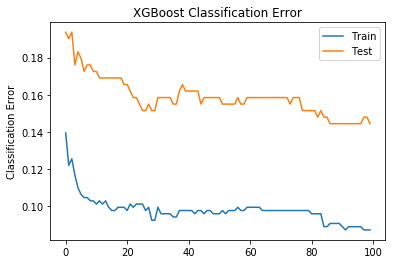

In [237]:
# Now plot our curves
d = plot_loss_and_error(clf, X_test, y_test)


Looks like we're overfitting to the training set from the outset and never improving.  While it's counterintuitive, let's try increasing from tree depth of 3 to 5 and see what happens:

In [238]:
# Train an XGB classifier
clf_1 = XGBClassifier(max_depth=5)

clf_1.fit(X_train, y_train, eval_set=eval_s)

[0]	validation_0-error:0.109756	validation_1-error:0.190141
[1]	validation_0-error:0.095819	validation_1-error:0.176056
[2]	validation_0-error:0.095819	validation_1-error:0.183099
[3]	validation_0-error:0.099303	validation_1-error:0.176056
[4]	validation_0-error:0.094077	validation_1-error:0.179577
[5]	validation_0-error:0.097561	validation_1-error:0.183099
[6]	validation_0-error:0.101045	validation_1-error:0.172535
[7]	validation_0-error:0.092334	validation_1-error:0.176056
[8]	validation_0-error:0.092334	validation_1-error:0.179577
[9]	validation_0-error:0.092334	validation_1-error:0.172535
[10]	validation_0-error:0.092334	validation_1-error:0.172535
[11]	validation_0-error:0.092334	validation_1-error:0.165493
[12]	validation_0-error:0.092334	validation_1-error:0.165493
[13]	validation_0-error:0.092334	validation_1-error:0.172535
[14]	validation_0-error:0.092334	validation_1-error:0.169014
[15]	validation_0-error:0.090592	validation_1-error:0.165493
[16]	validation_0-error:0.081882	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 84.51%


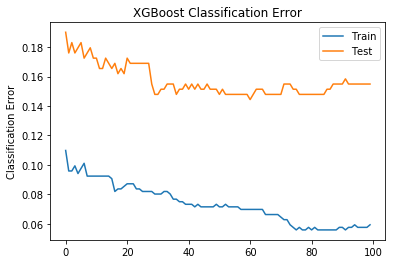

In [239]:
plot_loss_and_error(clf_1, X_test, y_test)

In [246]:
clf_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

No improvement.  Let's try again with a lower learning rate:

In [247]:
clf_2 = XGBClassifier(learning_rate=0.05)

clf_2.fit(X_train, y_train, eval_set=eval_s)

[0]	validation_0-error:0.139373	validation_1-error:0.193662
[1]	validation_0-error:0.121951	validation_1-error:0.190141
[2]	validation_0-error:0.121951	validation_1-error:0.190141
[3]	validation_0-error:0.125436	validation_1-error:0.197183
[4]	validation_0-error:0.118467	validation_1-error:0.193662
[5]	validation_0-error:0.118467	validation_1-error:0.179577
[6]	validation_0-error:0.120209	validation_1-error:0.179577
[7]	validation_0-error:0.116725	validation_1-error:0.190141
[8]	validation_0-error:0.120209	validation_1-error:0.183099
[9]	validation_0-error:0.116725	validation_1-error:0.183099
[10]	validation_0-error:0.108014	validation_1-error:0.183099
[11]	validation_0-error:0.10453	validation_1-error:0.183099
[12]	validation_0-error:0.106272	validation_1-error:0.183099
[13]	validation_0-error:0.102787	validation_1-error:0.176056
[14]	validation_0-error:0.10453	validation_1-error:0.176056
[15]	validation_0-error:0.102787	validation_1-error:0.176056
[16]	validation_0-error:0.10453	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 84.15%


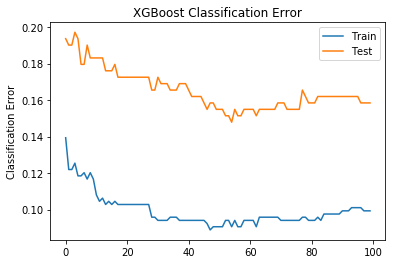

In [248]:
plot_loss_and_error(clf_2, X_test, y_test)

No improvement. At this point I'm concerned that the small size of the dataset is part of our problem... we're overfitting to the existing training data; while it might seem counterintuitive, let's add in more increase the ratio of train:test data (perhaps new training instances will remove some of the overconfidence).  Of course, at this point this has little to do with how we'd train a final model; we're doing this mostly to get a sense of how sensitive xgb is to changes in the train:test split of our dataset (especially since our dataset is small).

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

eval_s = [(X_train, y_train),(X_test, y_test)]

In [268]:
clf_4 = XGBClassifier()

clf_4.fit(X_train, y_train, eval_set=eval_s)

[0]	validation_0-error:0.134111	validation_1-error:0.122093
[1]	validation_0-error:0.134111	validation_1-error:0.145349
[2]	validation_0-error:0.135569	validation_1-error:0.139535
[3]	validation_0-error:0.131195	validation_1-error:0.127907
[4]	validation_0-error:0.131195	validation_1-error:0.127907
[5]	validation_0-error:0.131195	validation_1-error:0.127907
[6]	validation_0-error:0.131195	validation_1-error:0.133721
[7]	validation_0-error:0.131195	validation_1-error:0.127907
[8]	validation_0-error:0.129738	validation_1-error:0.122093
[9]	validation_0-error:0.125364	validation_1-error:0.127907
[10]	validation_0-error:0.125364	validation_1-error:0.127907
[11]	validation_0-error:0.125364	validation_1-error:0.127907
[12]	validation_0-error:0.123907	validation_1-error:0.127907
[13]	validation_0-error:0.123907	validation_1-error:0.116279
[14]	validation_0-error:0.119534	validation_1-error:0.127907
[15]	validation_0-error:0.120991	validation_1-error:0.116279
[16]	validation_0-error:0.118076	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 88.37%


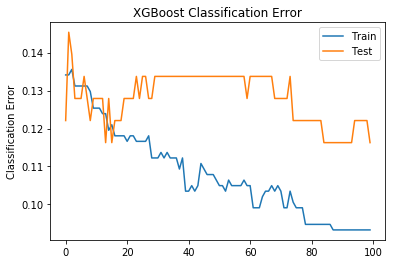

In [269]:
plot_loss_and_error(clf_4, X_test, y_test)

Even when changing the train:test split, we still overfit to the training set.  Our limited efforts at hyperparameter tuning for xgb have not yielded gains, likely due to the small size of our dataset.  Let's move on to training a final model with Logistic Regression, which is simpler and performs as well or better than xgb.  First, for fun, let's train an xgb classifier with default hyperparameter settings over our entier dataset and extract the feature importances.  Later, we'll compare to those from logistic regression.  

In [270]:
clf_5 = XGBClassifier()

clf_5.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

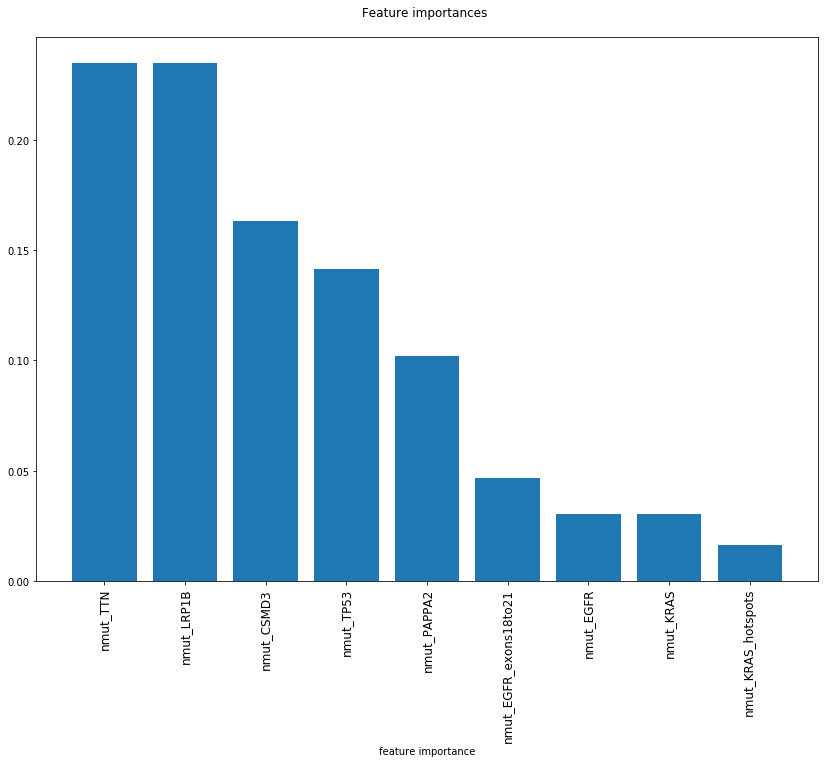

In [277]:
# Feature importances

num_feats = 9

importances = clf_5.feature_importances_

feats_importances = [(df_training.columns[i], importances[i]) for i in range(num_feats)]

feats_importances

feats_importances.sort(key=lambda tup: tup[1], reverse=True)

sorted_feats = [x[0] for x in feats_importances]
sorted_importances = [x[1] for x in feats_importances]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(14, 10, forward=True)
ax.bar(range(num_feats),sorted_importances[:num_feats])
ax.set_xticks(range(num_feats))
ax.set_xticklabels(sorted_feats[:num_feats], rotation='vertical', fontsize=12)
ax.set_xlabel("feature importance")
ax.set_title("Feature importances \n")
plt.show()

## Train a fina LRC binary classifier over all the training data and pickle it

Let's train a logistic regression binary classifier over our entire dataset that we can save and use on a demo website.  We'll use the default hyperparameteres for the classifier, since they were shown above to be best.

In [278]:
from sklearn.externals import joblib

In [279]:
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [57]:
joblib.dump(clf, '/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model.pkl') 

['/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model.pkl']

Let's check the feature importances of our logistic regression classifier.  Per this [stack overflow post](https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model), "One of the simplest options to get a feeling for the "influence" of a given parameter in a linear classification model (logistic being one of those), is to consider the magnitude of its coefficient times the standard deviation of the corresponding parameter in the data." Let's do that.

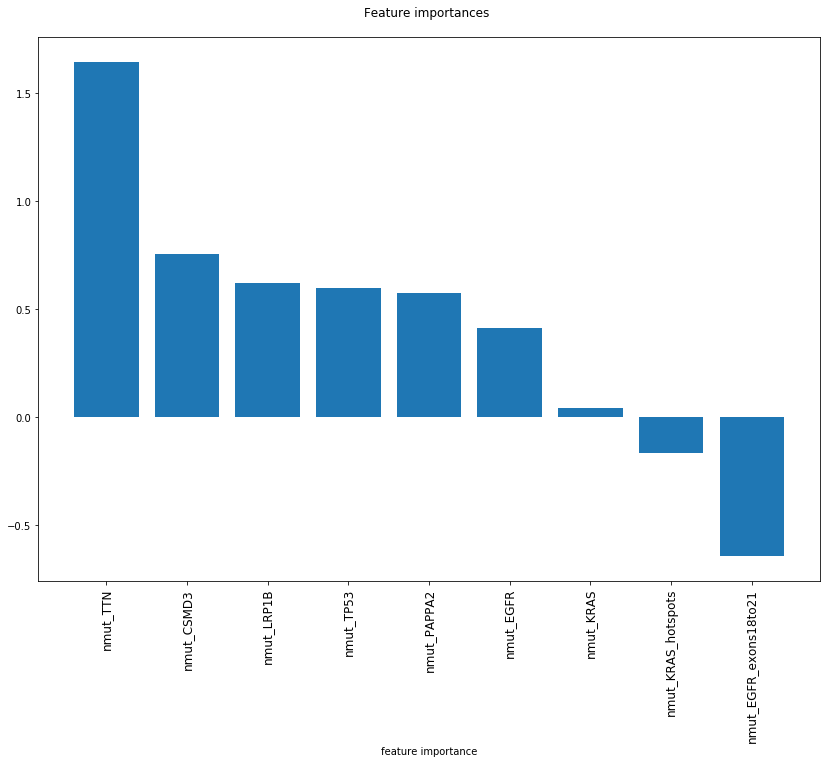

In [285]:
# Feature importances for logistic regression classifier

num_feats = 9

importances = np.std(X, 0)*clf.coef_

feats_importances = [(df_training.columns[i], importances[0][i]) for i in range(num_feats)]

feats_importances

feats_importances.sort(key=lambda tup: tup[1], reverse=True)

sorted_feats = [x[0] for x in feats_importances]
sorted_importances = [x[1] for x in feats_importances]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(14, 10, forward=True)
ax.bar(range(num_feats),sorted_importances[:num_feats])
ax.set_xticks(range(num_feats))
ax.set_xticklabels(sorted_feats[:num_feats], rotation='vertical', fontsize=12)
ax.set_xlabel("feature importance")
ax.set_title("Feature importances \n")
plt.show()

Note that negative values above mean that higher number of mutations in the given feature gene are associated with a more "negative" prediction (i.e. with a low TMB prediction).  Magnitudes should be considered mainly as a way to order feature importances; their literal interpretations are more nuanced.

We see a similar pattern as with xgb, with the one notable exception that our logistic regerssion model puts a stronger (negative) importance on the number of mutations in EGFR_exons18to21.  

# Some more experimentation

Let's run an experiment: We'll set a very high number of mutations in a given region, and 0s in all the others. The goal is to see if any of our regions give us unreasonable results

In [286]:
np.array(df_training.columns)[1]

'nmut_LRP1B'

In [287]:
muts = 1000

for i in range(len(X[0])):
    instance = [np.zeros(len(X[0]))]
    instance[0][i] = muts
    print(np.array(df_training.columns)[i])
    print(clf.predict_proba(instance))
    print()

nmut_TTN
[[0. 1.]]

nmut_LRP1B
[[0. 1.]]

nmut_CSMD3
[[0. 1.]]

nmut_PAPPA2
[[0. 1.]]

nmut_TP53
[[0. 1.]]

nmut_EGFR
[[0. 1.]]

nmut_KRAS
[[0. 1.]]

nmut_EGFR_exons18to21
[[1. 0.]]

nmut_KRAS_hotspots
[[1.00000000e+000 2.72967585e-162]]



Our last two features - EGFR_exons18to21 and KRAS_hotspots - behave unexpectedly, in that when we put an arbitrarily high number of mutations (1,000) for those features (and zero out mutation counts for all other feature genes), we get a strong prediction of low TMB.  What if we should omit these two columns from our dataset?  Out of curiosity, let's try it and see what we get.

In [289]:
lrc_cis = get_bootstrap_CIs(X[:,:7], y, lrc, use_weighting=False, num_bs_rounds=100, num_cv_folds=5)

Finished 0 rounds of bootstrapping out of 100

Mean AUC is: 0.9296225979602789
Mean Precision is: 0.7084412345748438
Mean Recall/Sensitivity is: 0.828159420289855
Mean Specificity is: 0.8746190476190479
Mean F1 Score is: 0.7620060431126059

95% AUC Confidence Interval is: (0.9266574649183343, 0.931904761904762)
95% Precision Confidence Interval is: (0.6965390429676144, 0.7215024024375952)
95% Recall/Sensitivity Confidence Interval is: (0.8156521739130435, 0.8423188405797102)
95% Specificity Confidence Interval is: (0.8666666666666668, 0.8825396825396826)
95% F1 Score Interval is: (0.7514951411695698, 0.7726211568525274)


We don't see much change. Let's try another experiment: bootstrapping an LRC with every possible combination of our feature columns:

In [303]:
import itertools

# Get every possible length of combination (1 through 9)
# Outerloop sets the number of features to include

features = list(df_training.columns)
feature_indexes = np.arange(0, len(features), 1)

perf_dict = {}

for L in range(1, len(features)+1):
    # Inner loop sets the indices of the feature(s) to include
    for subset in itertools.combinations(feature_indexes, L):
        print(subset)
        # Don't use bootstrapping (i.e. num_bs_rounds = 1) to save time
        lrc_cis = get_bootstrap_CIs(X[:,list(subset)], y, LogisticRegression(), \
                                    use_weighting=False, num_bs_rounds=1, num_cv_folds=5)
        # Save auc to a dict
        perf_dict[subset] = lrc_cis[0]

(0,)
Finished 0 rounds of bootstrapping out of 1

Mean AUC is: 0.8551272908519287
Mean Precision is: 0.8448696164738145
Mean Recall/Sensitivity is: 0.5003864734299517
Mean Specificity is: 0.9666666666666666
Mean F1 Score is: 0.6270812062807297

95% AUC Confidence Interval is: (0.8551272908519287, 0.8551272908519287)
95% Precision Confidence Interval is: (0.8448696164738145, 0.8448696164738145)
95% Recall/Sensitivity Confidence Interval is: (0.5003864734299517, 0.5003864734299517)
95% Specificity Confidence Interval is: (0.9666666666666666, 0.9666666666666666)
95% F1 Score Interval is: (0.6270812062807297, 0.6270812062807297)
(1,)
Finished 0 rounds of bootstrapping out of 1

Mean AUC is: 0.7631949237021701
Mean Precision is: 0.7155844155844155
Mean Recall/Sensitivity is: 0.3554589371980676
Mean Specificity is: 0.9476190476190476
Mean F1 Score is: 0.4675529880891013

95% AUC Confidence Interval is: (0.7631949237021701, 0.7631949237021701)
95% Precision Confidence Interval is: (0.71558441

In [323]:
import operator
best_feat_combo = max(perf_dict.items(), key=operator.itemgetter(1))[0]
print("Best-performing combination of feature genes:")
for col in df_training.columns[list(best_feat_combo)]:
    print(col)

print()
print("AUC : {}".format(max(perf_dict.values())[0]))

Best-performing combination of feature genes:
nmut_TTN
nmut_LRP1B
nmut_CSMD3
nmut_PAPPA2
nmut_TP53
nmut_EGFR_exons18to21
nmut_KRAS_hotspots

AUC : 0.9337884364695958



We see that the best result in terms of AUC came from using a subset of seven our features, and specifically omitting nmut_KRAS and nmut_EGFR.  However, the improvement does not appear to be significant, so we won't change our original logistic regression model for now.

What were the worst performing models?

In [408]:
worst_feat_combo = min(perf_dict.items(), key=operator.itemgetter(1))[0]
print("Worst-performing combination of feature genes:")
for col in df_training.columns[list(worst_feat_combo)]:
    print(col)

print()
print("AUC : {}".format(min(perf_dict.values())[0]))

Worst-performing combination of feature genes:
nmut_KRAS_hotspots

AUC : 0.4452722183881604


Let's plot the histogram of scores:

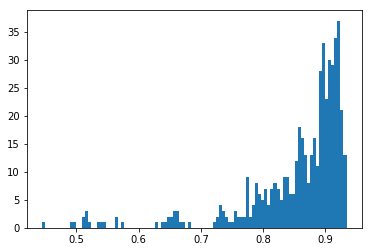

In [415]:
plt.hist([v[0] for v in perf_dict.values()], bins=100)
plt.show()

One last thing: for every distinct count of features (1-9), let's plot the histograms of scores from models with those numbers of features.

In [417]:
# First, we need to group our perf_dict items by key length

feat_count_dict = {}

for k, v in perf_dict.items():
    l = len(k)
    if l in feat_count_dict.keys():
        # Append the AUC (use the lower bound of the AUC CI for simplicity)
        feat_count_dict[l].append(v[0])
    else:
        feat_count_dict[l] = [v[0]]

In [418]:
feat_count_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

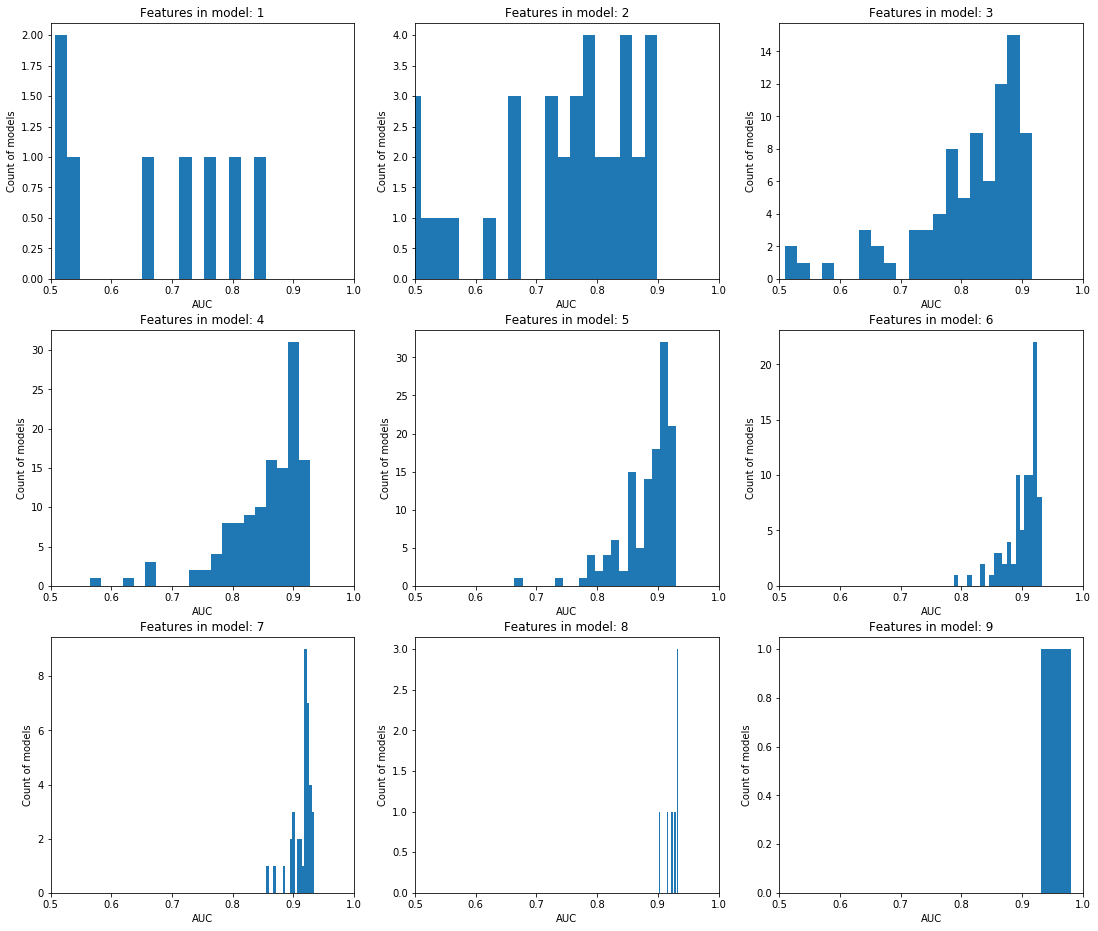

In [427]:
x = range(10)
y = range(10)

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.subplots_adjust(hspace=0.2)
fig.set_size_inches(18.5, 16)

i = 1
for row in ax:
    for col in row:
        col.hist(feat_count_dict[i], bins=20)
        col.set_title("Features in model: {}".format(i))
        col.set_xlim([0.5, 1.0])
#         col.set_ylim([0, 100])
        col.set_xlabel("AUC")
        col.set_ylabel("Count of models")
        col.axis('on')
        
#         median_mut = round(np.median(df[feature_column_names[i]]),2)
#         median_text = "Median mutations per case: {}".format(median_mut)        
        
#         mean_mut = round(np.mean(df[feature_column_names[i]]),2)
#         mean_text = "Mean mutations per case: {}".format(mean_mut)
        
#         # Get all cases with at least one mutation for the current gene
#         mut = df[feature_column_names[i]]
        
#         median_mut_nonzero = round(np.median(mut[mut > 0]),2)
#         median_text_nonzero = "Median mutations per case with >=1 mutation: {}".format(median_mut_nonzero)        
        
#         mean_mut_nonzero = round(np.mean(mut[mut > 0]),2)
#         mean_text_nonzero = "Mean mutations per case with >=1 mutation: {}".format(mean_mut_nonzero) 
        
#         total_cases_nonzero_share = round(float(len(mut[mut>0]))/float(len(mut)),2)
#         total_text_nonzero_share = "Share of cases with >=1 mutation: {}".format(total_cases_nonzero_share)
        
#         std_mut = round(np.std(df[feature_column_names[i]]),2)
#         std_text = "Stdev of mutations per case: {}".format(std_mut)
        
#         min_mut = round(np.min(df[feature_column_names[i]]),2)
#         min_text = "Min mutations per case: {}".format(min_mut)
        
#         max_mut = round(np.max(df[feature_column_names[i]]),2)
#         max_text = "Max mutations per case: {}".format(max_mut)
        
#         total_mut = round(np.sum(df[feature_column_names[i]]),2)
#         total_text = "Sum of mutations per case: {}".format(total_mut)        
        
#         col.text(0.5,-0.1, "\n" + median_text + "\n" + mean_text + "\n" + std_text + "\n" + min_text + 
#                  "\n" + max_text + "\n" + total_text + "\n" + median_text_nonzero + "\n" + mean_text_nonzero
#                  + "\n" + total_text_nonzero_share,
#                  size=12, ha="center", va="top", transform=col.transAxes)
        
        i += 1

        
plt.show()

We see that a number of models trained on low number of feature genes still have high AUCS.

## Now train a regression model that predicts TMB numeric value

So far, we've tackled the binary (high/low TMB) classification task.  Now, let's move on to predicting the actual (integer) TMB value.  For that, we'll need to move from classification models to regression models.  We have a few options, including multiple linear regression, regression trees, regression forrests, support vector regressors, and neural networks, to name a few.  We probably don't have enough data for a neural network to perform well, so we'll exclude neural networks.  Let's try some of the other regression models and see what performance we get.

To start, we need to get the labels for TMB in integer form (rather than the binary high/low).  Our labels for regression will be the raw count of mutations (not yet divided by 35 to get mutations per megabase; we'll do that at the end).

In [428]:
y = df['nmut'].values

Let's start with linear regression for a baseline.

In [429]:
from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression()

In [430]:
lr_clf.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [431]:
# "coefficient of determination R^2 of the prediction" from the docs 
lr_clf.score(X,y)

0.738068904078289

The above score is R-squared, and it tells us that our multiple linear regression model explains 74% of the variance in the data on which it was trained.  Let's let's try a decision tree regressor and see how it compares.

In [432]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

In [433]:
dtr_clf = DecisionTreeRegressor()

In [434]:
dtr_clf.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [341]:
dtr_clf.score(X,y)

0.9406281926479592

In [342]:
dtr_clf.feature_importances_

array([0.66777235, 0.06683377, 0.11257577, 0.08026302, 0.03855953,
       0.00844914, 0.00703273, 0.00670315, 0.01181054])

The decision tree regressor looks much better, and we haven't even done any hyperparameter tuning.  But is it overfitting the data?  Let's apply cross validation, though let's also be cautious of the potential [pitfalls](https://stats.stackexchange.com/questions/129937/how-to-compute-r-squared-value-when-doing-cross-validation) of doing so.  Let's give it a try anyhow.  We'll need to modify our cross validation to handle regression models and give R squared outputs.

In [437]:
def run_cross_validation_regression(X, y, model):

    r2s = []

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for train_index, test_index in skf.split(X, y):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        r = model.score(X_test, y_test)
        
        r2s.append(r**2)
        
    # return a tuple of the mean auc, precision recall/sensitivity, specificity, and f1 score
    return np.mean(r2s)

In [438]:
def get_bootstrap_CIs_regression(X, y, model, num_bs_rounds=100):
    bs_r2s= []
    
    # Do the bootstrapping and append the results
    for i in range(num_bs_rounds):
        result = run_cross_validation_regression(X, y, model)
        bs_r2s.append(result)
        
        if i%100 == 0:
            print("Finished {} rounds of bootstrapping out of {}".format(i, num_bs_rounds))
    print()
        
    sorted_bs_r2s = np.array(bs_r2s)
    sorted_bs_r2s.sort()
    r2_ci_lower = sorted_bs_r2s[int(0.05 * len(sorted_bs_r2s))]
    r2_ci_upper = sorted_bs_r2s[int(0.95 * len(sorted_bs_r2s))]
    r2_ci = (r2_ci_lower, r2_ci_upper)
    
    print("Mean R Squared is: {}".format(np.mean(bs_r2s)))
    print("")
    print("95% R Squared Confidence Interval is: {}".format(r2_ci))
    
    return

Let's start with linear regression:

In [439]:
get_bootstrap_CIs_regression(X, y, LinearRegression())

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.5104661636059529

95% R Squared Confidence Interval is: (0.4892697703380985, 0.5263435863931932)


Next let's look at regression tree performance with bootstrapping of cross validation.

In [441]:
get_bootstrap_CIs_regression(X, y, DecisionTreeRegressor())

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.26737827687823734

95% R Squared Confidence Interval is: (0.2089807638131036, 0.32536088037978056)


That's much worse that linear regression (and the CI range is pretty wide).  Let's try regression forests next.

In [442]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

By default, the RandomForestRegressor uses 10 trees with no cap on tree depth, and splits on mean squared error (with no constraints around leaf purity):

In [443]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [444]:
get_bootstrap_CIs_regression(X, y, RandomForestRegressor())

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.44075068243151544

95% R Squared Confidence Interval is: (0.402350396380461, 0.47534976552876723)


The random forest regressor improved on the decision tree regressor, with just the default hyperparameters.  Can we get further improvement from some hyperparameter tuning?  Let's try some other max tree depths (note: I tried several, and the best one is below, with max_depth=5).

In [445]:
get_bootstrap_CIs_regression(X, y, RandomForestRegressor(max_depth=5))

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.4840759415010096

95% R Squared Confidence Interval is: (0.4551703518853147, 0.5123514687488465)


Next, let's see if adding more trees can help (bump it up from 10 trees to 50).

In [446]:
get_bootstrap_CIs_regression(X, y, RandomForestRegressor(max_depth=5, n_estimators=50))

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.494177466050959

95% R Squared Confidence Interval is: (0.46618605017759823, 0.5185303538046966)


Linear regression still edges out the regression forest (though the confidence intervals overlap).  Let's go with multiple linear regression for simplicity (it also has the benefit of allowing us to directly interpret the regression coefficients).  Let's check if we get any improvement in multiple linear regression performance by normalizing the inputs:

In [447]:
get_bootstrap_CIs_regression(X, y, LinearRegression(normalize=True))

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.5097204346337016

95% R Squared Confidence Interval is: (0.4886442335362496, 0.531207277203894)


Normalizing the inputs helped a bit, though the CIs still overlap that of linear regression.

Let's try one more thing: an xgboost regressor:

In [448]:
xgb_rgr = XGBRegressor()
get_bootstrap_CIs_regression(X, y, xgb_rgr)

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.49076969218654126

95% R Squared Confidence Interval is: (0.4593867420364431, 0.5172431838639073)


The out-of-the-box XGB regressor couldn't beat multiple linear regression. Let's try setting the max tree depth to 5 (which was our best result for random forests).

In [449]:
xgb_rgr = XGBRegressor(max_depth=5)
get_bootstrap_CIs_regression(X, y, xgb_rgr)

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.48261110675240887

95% R Squared Confidence Interval is: (0.4443993920067408, 0.513237911246742)


No improvement.  What if we lower the learning rate and increase the number of epochs?

In [450]:
# That made it worse! Let's try one more: max depth of 10
xgb_rgr = XGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=200)
get_bootstrap_CIs_regression(X, y, xgb_rgr)

Finished 0 rounds of bootstrapping out of 100

Mean R Squared is: 0.48373633930579607

95% R Squared Confidence Interval is: (0.45438637134956467, 0.5174682905952807)


XGB still doesn't perform better than linear regression, so we'll go with the latter for the demo website model.

In [367]:
lr_demosite = LinearRegression()

In [368]:
lr_demosite.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [369]:
lr_demosite.predict([[0,0,0,0,0,0,0,0,0]])

array([76.9654833])

In [371]:
cols_and_coefs = zip(list(df_training.columns), lr_demosite.coef_)
for e in cols_and_coefs:
    print(e)

('nmut_TTN', 60.250923595999986)
('nmut_LRP1B', 53.19481610087949)
('nmut_CSMD3', 58.57629316692863)
('nmut_PAPPA2', 91.57906734979467)
('nmut_TP53', 67.1916167705261)
('nmut_EGFR', 95.00206280844051)
('nmut_KRAS', -89.03644731696012)
('nmut_EGFR_exons18to21', -111.54195382622596)
('nmut_KRAS_hotspots', 102.25575547492737)


Two of our features have negative coefficients: nmut_KRAS and nmut_EGFR_exons18to21 (oddly, their counterparts have positive coefficients).  I'm uncomfortable with the outsized influence of features which we know from earlier analysis have little or not correlation with TMB.  Let's revisit our best performing XGB regressor and check feature importances to see if they seem more reasonable:

In [372]:
xgb_rgr = XGBRegressor()
xgb_rgr.fit(X,y)
xgb_rgr.feature_importances_

array([0.32209107, 0.15177065, 0.16020235, 0.15177065, 0.07588533,
       0.02698145, 0.04384486, 0.03541315, 0.03204047], dtype=float32)

This looks a *lot* more in line with what we saw in the pair plot and in the plots of individual features against TMB.  We'll go with the XGB Regressor.

In [79]:
# Pickle the model for use on the demo site; we can replace it if we train a better model.
joblib.dump(xgb_rgr, '/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model-cont-xgb.pkl') 

['/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model-cont-xgb.pkl']

Update: we're having problems getting xgboost to work with the demo site for now.  For now we'll have to stick with multiple linear regression.  But for publishing results, we'll go with XGB.

In [267]:
# Pickle the model for use on the demo site; we can replace it if we train a better model.
joblib.dump(lr_demosite, '/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model-cont.pkl') 

['/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model-cont.pkl']

### A little more experimentation with features

Let's use ANOVA to look at the F values and p values of our features.  From this [stats.stackexchange post](https://stats.stackexchange.com/questions/20341/the-disadvantage-of-using-f-score-in-feature-selection), "F-score reveals the discriminative power of each feature independently from the others.  But it does not indicate anything on the combination of... features (mutual information). This is the main weakness of F-score."

Note that F-score does **NOT** get at directionality, only at power.  From the same stats.stackexchange article, "F-score is a ratio of two variables: F = F1/F2, where F1 is the variability between groups and F2 is the variability within each group.  In other words, a high F value (leading to a significant p-value) means that at least one of your groups is significantly different from the rest... Typically you select features that return high F-values and use those for further analysis." (But there are catches..)

In [374]:
from sklearn.feature_selection import f_regression

In [375]:
f_values, p_values = f_regression(X,y)

In [130]:
df_training.columns

Index(['nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53',
       'nmut_EGFR', 'nmut_KRAS', 'nmut_EGFR_exons18to21',
       'nmut_KRAS_hotspots'],
      dtype='object')

F scores (order corresponds to features in the above cell):

In [126]:
f_values

array([1.36094789e+03, 4.12732287e+02, 5.40406709e+02, 3.36039399e+02,
       1.24490801e+02, 3.21627274e-02, 3.16087701e+00, 5.71222219e+00,
       1.15057883e+00])

p values associated with those F scores:

In [127]:
p_values

array([4.53564509e-179, 3.42608583e-075, 4.72705304e-093, 1.43099069e-063,
       4.37783301e-027, 8.57713418e-001, 7.57775900e-002, 1.70625877e-002,
       2.83730316e-001])

In [380]:
# Zip it all up

feat_f_and_p = [(df_training.columns[i], f_values[i], p_values[i]) for i in range(9)]

for tup in feat_f_and_p:
    print("Feature: {} \t F-value: {} \t p-value: {}".format(tup[0], tup[1], tup[2]))

Feature: nmut_TTN 	 F-value: 1360.9478921108425 	 p-value: 4.5356450910439576e-179
Feature: nmut_LRP1B 	 F-value: 412.7322872010067 	 p-value: 3.4260858277333856e-75
Feature: nmut_CSMD3 	 F-value: 540.4067090188016 	 p-value: 4.727053035470166e-93
Feature: nmut_PAPPA2 	 F-value: 336.0393992299047 	 p-value: 1.4309906935796841e-63
Feature: nmut_TP53 	 F-value: 124.49080117550463 	 p-value: 4.3778330122404906e-27
Feature: nmut_EGFR 	 F-value: 0.03216272743316597 	 p-value: 0.8577134179125703
Feature: nmut_KRAS 	 F-value: 3.1608770138447664 	 p-value: 0.07577759001532983
Feature: nmut_EGFR_exons18to21 	 F-value: 5.712222186496385 	 p-value: 0.017062587712044903
Feature: nmut_KRAS_hotspots 	 F-value: 1.1505788291747843 	 p-value: 0.2837303162875652


These results are largely in agreement with the ordering of feature importances from Logistic Regression and XGBoost.  Let's see what [mutual information](https://en.wikipedia.org/wiki/Mutual_information) (for regression) has to say about for each of our feature genes with respect to TMB:

In [381]:
from sklearn.feature_selection import mutual_info_regression

In [382]:
mutual_info = mutual_info_regression(X,y, discrete_features=True)

In [385]:
# Zip is all up

feat_f_and_p = [(df_training.columns[i], mutual_info[i]) for i in range(9)]

for tup in feat_f_and_p:
    print("Feature: {} \t Mutual info with TMB: {}".format(tup[0], tup[1]))

Feature: nmut_TTN 	 Mutual info with TMB: 0.36585795757133077
Feature: nmut_LRP1B 	 Mutual info with TMB: 0.1956816373706438
Feature: nmut_CSMD3 	 Mutual info with TMB: 0.2505410317158612
Feature: nmut_PAPPA2 	 Mutual info with TMB: 0.1008966096383841
Feature: nmut_TP53 	 Mutual info with TMB: 0.10191891157994304
Feature: nmut_EGFR 	 Mutual info with TMB: 0.03891556810072405
Feature: nmut_KRAS 	 Mutual info with TMB: 0.04615884181881813
Feature: nmut_EGFR_exons18to21 	 Mutual info with TMB: 0.05524265981340459
Feature: nmut_KRAS_hotspots 	 Mutual info with TMB: 0.0475778712903403


The ordering of our features based on their magnitudes of mutual information with the label is in agreement with the ordering based on F scores: TTN has the highest mutual information with TMB, followed by CSMD3 and LRP1B, and there's a steep dropoff for the other features after that.

However, recall that in mutual information, "there are cases in which a single feature is useless but given more features it becomes important" (source: [datascience.stackexchange](https://datascience.stackexchange.comquestions/12382/feature-selection-techniques/12434)).

## Predict on a new validation set

Below, we use our binary classifier and regression model to generate predictions for a validation set (whose labels we don't know).

We start by importing the validation set, which is in the same formate as the training set.

In [186]:
val_df = pd.read_csv('LUADvalidation_Mick.csv')

In [187]:
# Get rid of null columns
val_df = val_df[['Sample', 'ttype', 'nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 
                'nmut_EGFR', 'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']]

In [188]:
# Get rid of null rows
val_df.dropna(inplace=True, axis=0)

In [189]:
val_df.columns

Index(['Sample', 'ttype', 'nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3',
       'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR', 'nmut_KRAS',
       'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots'],
      dtype='object')

In [190]:
val_df.shape

(171, 11)

In [191]:
val_X = val_df[['nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 
                'nmut_EGFR', 'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']]

In [192]:
binary_predictions = lrc.predict(val_X.values)

In [193]:
regression_predictions_mutation_count = lr_validation.predict(val_X.values)

In [194]:
regression_predictions_mutations_per_mb = [x / 35.0 for x in regression_predictions_mutation_count]

In [57]:
#regression_predictions_mutations_per_mb

Finally, we add on our prediction columns to the original dataframe and export it as a CSV to send back to Joe for scoring:

In [200]:
val_df['binary_predictions'] = pd.Series(binary_predictions)

In [201]:
val_df['mutation_count_predictions'] = pd.Series(regression_predictions_mutation_count)

In [202]:
val_df['mutations_per_mb_predictions'] = pd.Series(regression_predictions_mutations_per_mb)

In [204]:
val_df['bin_predictions'] = val_df['binary_predictions'].apply(lambda x : "HIGH" if x == 1 else "LOW")

In [206]:
val_df.drop(['binary_predictions'], axis=1, inplace=True)

In [208]:
val_df['binary_predictions'] = val_df['bin_predictions']

In [210]:
val_df.drop(['bin_predictions'], axis=1, inplace=True)

In [211]:
val_df.head(5)

,Sample,ttype,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots,binary_predictions,mutation_count_predictions,mutations_per_mb_predictions
0,SU2CLC-MGH-1412-TM-01,LUAD,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,LOW,90.184791,2.576708
1,SU2CLC-MGH-1414-TM-01,LUAD,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,LOW,217.627332,6.217924
2,SU2CLC-MGH-1415-TM-01,LUAD,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,HIGH,456.956396,13.055897
3,SU2CLC-MGH-1416-TM-01,LUAD,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,LOW,217.627332,6.217924
4,SU2CLC-MGH-1417-TM-01,LUAD,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,LOW,316.147092,9.032774


In [212]:
val_df.to_csv('LUADvalidation_Mick_WITH_PREDICTIONS.csv')

## Results of predictions on blinded dataset (error analysis)

Update: we've now been given an unblinded validation dataset; let's read it in:

In [4]:
unblinded_df = pd.read_csv('LUADvalidation_unblinded_results.csv')

In [6]:
unblinded_df.columns

Index(['Sample', 'Sample.1', 'check ID', 'Total mutation count', 'Mut/MB',
       'Exome', 'ttype', 'nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2',
       'nmut_TP53', 'nmut_EGFR', 'nmut_KRAS', 'nmut_EGFR_exons18to21',
       'nmut_KRAS_hotspots', 'binary_predictions',
       'mutation_count_predictions', 'mutations_per_mb_predictions', 'Exome.1',
       'Mick', 'combined'],
      dtype='object')

In [7]:
unblinded_df.head(5)

,Sample,Sample.1,check ID,Total mutation count,Mut/MB,Exome,ttype,nmut_TTN,nmut_LRP1B,nmut_CSMD3,...,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots,binary_predictions,mutation_count_predictions,mutations_per_mb_predictions,Exome.1,Mick,combined
0,SU2CLC-MGH-1412-TM-01,SU2CLC-MGH-1412-TM-01,1,310,8.857143,LOW,LUAD,0,0,0,...,0,1,0,1,LOW,90.184791,2.576708,0,0,0
1,SU2CLC-MGH-1414-TM-01,SU2CLC-MGH-1414-TM-01,1,322,9.200000,LOW,LUAD,1,0,0,...,0,1,0,1,LOW,217.627332,6.217924,0,0,0
2,SU2CLC-MGH-1415-TM-01,SU2CLC-MGH-1415-TM-01,1,472,13.485714,HIGH,LUAD,4,0,1,...,0,1,0,1,HIGH,456.956396,13.055897,1,1,11
3,SU2CLC-MGH-1416-TM-01,SU2CLC-MGH-1416-TM-01,1,322,9.200000,LOW,LUAD,1,0,0,...,0,1,0,1,LOW,217.627332,6.217924,0,0,0
4,SU2CLC-MGH-1417-TM-01,SU2CLC-MGH-1417-TM-01,1,284,8.114286,LOW,LUAD,0,0,0,...,0,1,0,1,LOW,316.147092,9.032774,0,0,0


Let's start by confirming the metrics Joe observed (remember that sensitivity == recall)

In [10]:
# Sensitivity
sensitivity = recall_score(unblinded_df['Exome.1'], unblinded_df['Mick'])

# Specificity
specificity = get_specificity(unblinded_df['Exome.1'], unblinded_df['Mick'])

In [11]:
sensitivity

0.625

In [12]:
specificity

0.9391304347826087

Now, let's do some error analysis.  Firstly, we suspect that errors made by the binary classifier will cluster around cases where the true TMB is close to 10. Let's see if that's true, by comparing the distributions of TMBs in the cases our binary classifier predicted correctly vs. the cases where it was wrong:

In [15]:
correct_df = unblinded_df[unblinded_df['Exome.1'] == unblinded_df['Mick']]
incorrect_df = unblinded_df[unblinded_df['Exome.1'] != unblinded_df['Mick']]

In [16]:
print(correct_df.shape)
print(incorrect_df.shape)

(143, 22)
(28, 22)


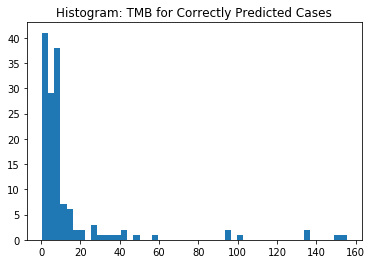

Median Mut/MB: 6.914285714
Mean Mut/MB: 14.403196803363635


In [21]:
plt.hist(correct_df['Mut/MB'], bins=50)
plt.title('Histogram: TMB for Correctly Predicted Cases')
plt.show()
print("Median Mut/MB: {}".format(np.median(correct_df['Mut/MB'])))
print("Mean Mut/MB: {}".format(np.mean(correct_df['Mut/MB'])))

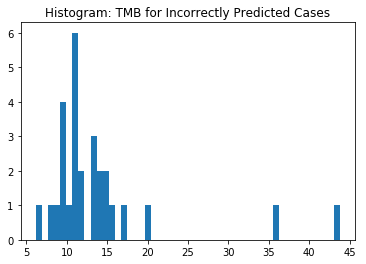

Median Mut/MB: 11.3
Mean Mut/MB: 13.958163265357141


In [20]:
plt.hist(incorrect_df['Mut/MB'], bins=50)
plt.title('Histogram: TMB for Incorrectly Predicted Cases')
plt.show()
print("Median Mut/MB: {}".format(np.median(incorrect_df['Mut/MB'])))
print("Mean Mut/MB: {}".format(np.mean(incorrect_df['Mut/MB'])))

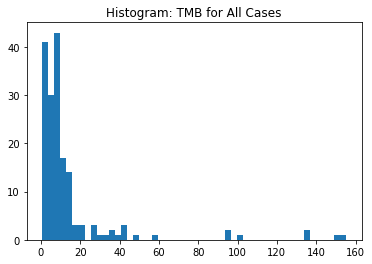

Median Mut/MB: 7.8
Mean Mut/MB: 14.33032581468421


In [22]:
plt.hist(unblinded_df['Mut/MB'], bins=50)
plt.title('Histogram: TMB for All Cases')
plt.show()
print("Median Mut/MB: {}".format(np.median(unblinded_df['Mut/MB'])))
print("Mean Mut/MB: {}".format(np.mean(unblinded_df['Mut/MB'])))

Due to outliers with high TMB, median is the more robust metric above.  We do see that the median TMB for the incorrectly predicted cases (11.3) was closer to the low/high margin than the median for correctly predicted cases (6.9).

We also note that the median TMB for correctly predicted cases falls below the median TMB for all cases, while the median TMB for incorrectly predicted cases falls above the median TMB for all cases.  This confirms our model's bias at overpredicting low TMB and underpredicting high TMB, which likely comes from the label skewness in the training dataset, in which ~75% of the rows were LOW.

With that said, our binary classifier did miss a few outliers on the extreme high TMB end (TMB of 20+).

It's worth noting that the binary TMB label of low is defined by human experts and not nature; if that threshold was redefined, the classifier's performance could change.  This is why it is also important to predict integer TMB value.  So in our error analysis, while it is worth looking for mutation profiles where the binary classifier performs well vs. poorly, we must still tie those profiles back to TMB values- specifically, we may find that mutation profiles for which the binary classifier predicts poorly are those that tend to have TMBs around the binary margin (10 mut per mb).

## Prediction on the Final validation set (5/5/2019)

In [388]:
final_val_df = pd.read_csv('MGH_exomes_19April2019.TMB.data.v1.0.csv', delimiter='\t')

In [389]:
final_val_df.head(3)

,name,ttype,nmut,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots
0,SU2CLC-MGH-1499-TM-01,LUAD,3,0,0,0,0,0,0,0,0,0
1,SU2CLC-MGH-1577-TM-01,LUAD,8,0,0,0,0,0,0,0,0,0
2,SU2CLC-MGH-1413-TM-01,LUAD,10,0,0,0,0,0,0,0,0,0


In [390]:
final_val_df.columns

Index(['name', 'ttype', 'nmut', 'nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3',
       'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR', 'nmut_KRAS',
       'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots'],
      dtype='object')

In [391]:
final_val_df.isnull().values.any()

False

In [392]:
final_val_df.shape

(71, 12)

Our validation set has (only) 71 instances.  That's not a lot... just keep it in mind.  We should also check whether it matches with the training set (i.e. mutational profiles are similarly distributed)

In [393]:
final_val_X = final_val_df[['nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 
                'nmut_EGFR', 'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']]

In [400]:
# xgb_rgr = XGBRegressor()
# xgb_rgr.fit(X,y)

lin_rgr = LinearRegression()
lin_rgr.fit(X,y_continuous)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [401]:
nmut_predicted = lin_rgr.predict(final_val_X.values)

In [402]:
# Round mutation predictions to integers
nmut_predicted = [int(np.round(e,0)) for e in nmut_predicted]

In [403]:
final_val_df['predicted_nmut'] = pd.Series(nmut_predicted)

In [404]:
final_val_df.tail()

,name,ttype,nmut,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots,predicted_nmut
66,SU2CLC-MGH-1054-TM-01_1,LUAD,903,6,3,2,0,1,0,0,0,0,782
67,SU2CLC-MGH-1054-TM-01,LUAD,956,10,4,2,0,1,0,0,0,0,1077
68,SU2CLC-MGH-1131-TM-01,LUAD,1273,6,3,5,0,1,0,0,0,0,958
69,SU2CLC-MGH-1048-TM-01,LUAD,1328,25,8,1,1,1,0,0,0,0,2226
70,SU2CLC-MGH-1044-TM-01,LUAD,2269,19,1,6,2,2,0,0,0,0,1944


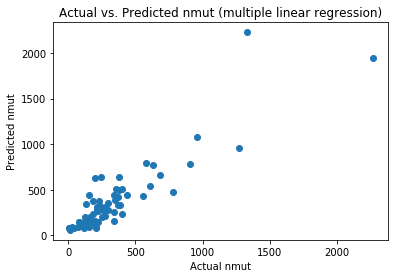

line of best fit: 0.94x +58.63
r-squared: 0.8
standard error: 0.06


In [405]:
plt.scatter(final_val_df.nmut, final_val_df.predicted_nmut)
plt.xlabel("Actual nmut")
plt.ylabel("Predicted nmut")
plt.title("Actual vs. Predicted nmut (multiple linear regression)")
plt.show()

# Get the r-squared for the line of best fit for
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(final_val_df.nmut, final_val_df.predicted_nmut)
print("line of best fit: {}".format(str(round(slope,2))+"x +"+str(round(intercept,2))))
print("r-squared: {}".format(round(r_value**2,2)))
print("standard error: {}".format(round(std_err,2)))

In [455]:
# 9/30/19 for Joe: get predictions on the training set (X)

nmut_predicted_on_train = lin_rgr.predict(X)
# Round mutation predictions to integers
nmut_predicted_on_train =[int(np.round(e,0)) for e in nmut_predicted_on_train]

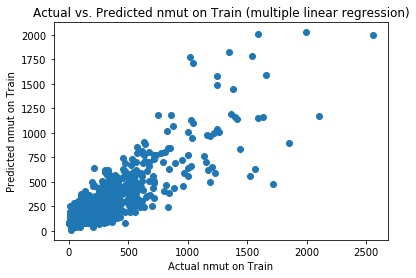

line of best fit: 0.74x +72.79
r-squared: 0.74
standard error: 0.02


In [458]:
plt.scatter(y_continuous, nmut_predicted_on_train)
plt.xlabel("Actual nmut on Train")
plt.ylabel("Predicted nmut on Train")
plt.title("Actual vs. Predicted nmut on Train (multiple linear regression)")
plt.show()

# Get the r-squared for the line of best fit for
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_continuous, nmut_predicted_on_train)
print("line of best fit: {}".format(str(round(slope,2))+"x +"+str(round(intercept,2))))
print("r-squared: {}".format(round(r_value**2,2)))
print("standard error: {}".format(round(std_err,2)))

Interesting: R squared for the training set is actually slightly worse than for the validation set, which is generally unusual.

In [94]:
# Write it out to a csv and sent it to joe (need to put back from numpy -> pandas first)
train_for_joe_df = df.copy()
train_for_joe_df.shape

(858, 15)

In [92]:
len(y)

858

In [95]:
train_for_joe_df.columns

Index(['name', 'ttype', 'nmut', 'mut_per_mb', 'binary_label', 'nmut_TTN',
       'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 'nmut_EGFR',
       'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots', 'sum_muts'],
      dtype='object')

In [96]:
train_for_joe_df['nmut_predicted'] = nmut_predicted_on_train

In [98]:
# Write out the training set for Joe
train_for_joe_df.to_csv("training_set_with_predicted_nmut.csv", sep='\t')

In [184]:
final_val_df.to_csv("validation_set_with_predicted_nmut_2019_05_05.csv", sep='\t')

In [192]:
# Let's get the regression coefficients
cols_and_coefs = zip(list(df_training.columns), lin_rgr.coef_)
for e in cols_and_coefs:
    print(e[0] + ": " + str(int(round(e[1],0))))

nmut_TTN: 60
nmut_LRP1B: 53
nmut_CSMD3: 59
nmut_PAPPA2: 92
nmut_TP53: 67
nmut_EGFR: 95
nmut_KRAS: -89
nmut_EGFR_exons18to21: -112
nmut_KRAS_hotspots: 102


## Performance assessment on validation set: classification vs. regression

Using the (unblinded) validation set provided by Joe, we'll calculate accuracy, precision, recall, and F1 for the binary classification case.  We'll do this both with our logistic regression classifier, and with our linear regressor (converting the continuous outputs to binary).

We begin by loading in the validation set.

In [33]:
final_val_df = pd.read_csv('MGH_exomes_19April2019.TMB.data.v1.0.csv', delimiter='\t')

In [34]:
final_val_df.head(3)

,name,ttype,nmut,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots
0,SU2CLC-MGH-1499-TM-01,LUAD,3,0,0,0,0,0,0,0,0,0
1,SU2CLC-MGH-1577-TM-01,LUAD,8,0,0,0,0,0,0,0,0,0
2,SU2CLC-MGH-1413-TM-01,LUAD,10,0,0,0,0,0,0,0,0,0


In [35]:
# Now, load our final logistic regression classifier

clf = joblib.load('/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model.pkl')

In [37]:
# Make our binary predictions from the LRC

final_val_X = final_val_df[['nmut_TTN', 'nmut_LRP1B', 'nmut_CSMD3', 'nmut_PAPPA2', 'nmut_TP53', 
                'nmut_EGFR', 'nmut_KRAS', 'nmut_EGFR_exons18to21', 'nmut_KRAS_hotspots']]

clf_pred = clf.predict(final_val_X.values)

In [39]:
final_val_df['clf_prediction'] = pd.Series(clf_pred)

Now, repeat with our regressor (to generate binary predictions from it)

In [40]:
reg = joblib.load('/Users/mzomnir/Desktop/TMB_prediction/backend/tmb-model-cont.pkl')

In [41]:
reg_pred = reg.predict(final_val_X.values)

In [43]:
# Recall: 10 mutations per MB is the low/high cutoff, and we get mutations per MB by dividing total mutation count by 35

reg_pred_binary = [0 if x < 350 else 1 for x in reg_pred]

In [45]:
final_val_df['reg_binary_prediction'] = pd.Series(reg_pred_binary)

In [ ]:
# Now we add in a column with tht actual binary truth

In [46]:
final_val_df['binary_truth'] = final_val_df['nmut'].apply(lambda x: 0 if x < 350 else 1)

In [48]:
c.tail(3)

,name,ttype,nmut,nmut_TTN,nmut_LRP1B,nmut_CSMD3,nmut_PAPPA2,nmut_TP53,nmut_EGFR,nmut_KRAS,nmut_EGFR_exons18to21,nmut_KRAS_hotspots,clf_prediction,reg_binary_prediction,binary_truth
68,SU2CLC-MGH-1131-TM-01,LUAD,1273,6,3,5,0,1,0,0,0,0,1,1,1
69,SU2CLC-MGH-1048-TM-01,LUAD,1328,25,8,1,1,1,0,0,0,0,1,1,1
70,SU2CLC-MGH-1044-TM-01,LUAD,2269,19,1,6,2,2,0,0,0,0,1,1,1


Time to compute our performance metrics; start with the logistic regression classifier.

In [51]:
clf_accuracy = float(len(final_val_df[final_val_df['clf_prediction'] == final_val_df['binary_truth']]) / float(len(final_val_df)))

In [52]:
clf_accuracy

0.8873239436619719

In [53]:
clf_precision = precision_score(final_val_df['binary_truth'], final_val_df['clf_prediction'])

In [54]:
clf_precision

0.782608695652174

In [55]:
clf_recall_sensitivity = recall_score(final_val_df['binary_truth'], final_val_df['clf_prediction'])

In [56]:
clf_recall_sensitivity

0.8571428571428571

In [60]:
clf_f1 = f1_score(final_val_df['binary_truth'], final_val_df['clf_prediction'])

In [61]:
clf_f1

0.8181818181818182

In [58]:
clf_specificity = get_specificity(final_val_df['binary_truth'], final_val_df['clf_prediction'])

In [59]:
clf_specificity

0.9

Rinse and repeat, now with our binarized linear regressor

In [62]:
reg_accuracy = float(len(final_val_df[final_val_df['reg_binary_prediction'] == final_val_df['binary_truth']]) / float(len(final_val_df)))

In [63]:
reg_accuracy

0.8591549295774648

In [64]:
reg_precision = precision_score(final_val_df['binary_truth'], final_val_df['reg_binary_prediction'])

In [65]:
reg_precision

0.72

In [66]:
reg_recall_sensitivity = recall_score(final_val_df['binary_truth'], final_val_df['reg_binary_prediction'])

In [67]:
reg_recall_sensitivity

0.8571428571428571

In [68]:
reg_f1 = f1_score(final_val_df['binary_truth'], final_val_df['reg_binary_prediction'])

In [69]:
reg_f1

0.782608695652174

In [70]:
reg_specificity = get_specificity(final_val_df['binary_truth'], final_val_df['reg_binary_prediction'])

In [71]:
reg_specificity

0.86

The logistic regression classifier slightly outperforms the linear-regressor-turned-classifier on all metrics except sensitity (on which it's tied).